# DFT 调参

In [1]:
import os
import sys
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
current_path = os.getcwd()

# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path))
# Importing the custom module
from Utools.draw import plot_feature_importance
from Utools.SingleModel import SingleModel


In [2]:
# Load data (assuming you have dft_train_X, dft_train_y)
file_dir = os.path.join(current_path, './Data')
# Load dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_train_set.csv'))
dft_all_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_all_train_y = dft_train['band_gap']
# Load dft test data
dft_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_test_set.csv'))
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
dft_all_train_X.shape, dft_all_train_y.shape, dft_test_X.shape, dft_test_y.shape

((8275, 64), (8275,), (2067, 64), (2067,))

In [3]:
# 从dft_train_X中抽取出一份验证集
mp_unique_comp = dft_train['composition'].unique()
len(mp_unique_comp)

8244

In [4]:
import random
# 从mp_unique_comp中随机采样组成
random.seed(RANDOM_SEED)
random_index = random.sample(range(len(mp_unique_comp)), round(len(mp_unique_comp)*0.2))
mp_val_comp = mp_unique_comp[random_index]
dft_train_set = dft_train[~dft_train['composition'].isin(mp_val_comp)]
dft_val_set = dft_train[dft_train['composition'].isin(mp_val_comp)]
print(f'MP训练集大小：{len(dft_train_set)}')
print(f'MP验证集大小：{len(dft_val_set)}')

MP训练集大小：6620
MP验证集大小：1655


In [5]:
# Prepare data
dft_train_X = dft_train_set.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train_set['band_gap']
# 
dft_val_X = dft_val_set.drop(columns=['composition', 'band_gap'])
dft_val_y = dft_val_set['band_gap']

dft_train_X.shape, dft_train_y.shape, dft_val_X.shape, dft_val_y.shape

((6620, 64), (6620,), (1655, 64), (1655,))

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Pipeline] ............. (step 2 of 2) Processing model, total=  52.4s
Model training completed!
[Train Error] Evaluating DFT GBR on train set:


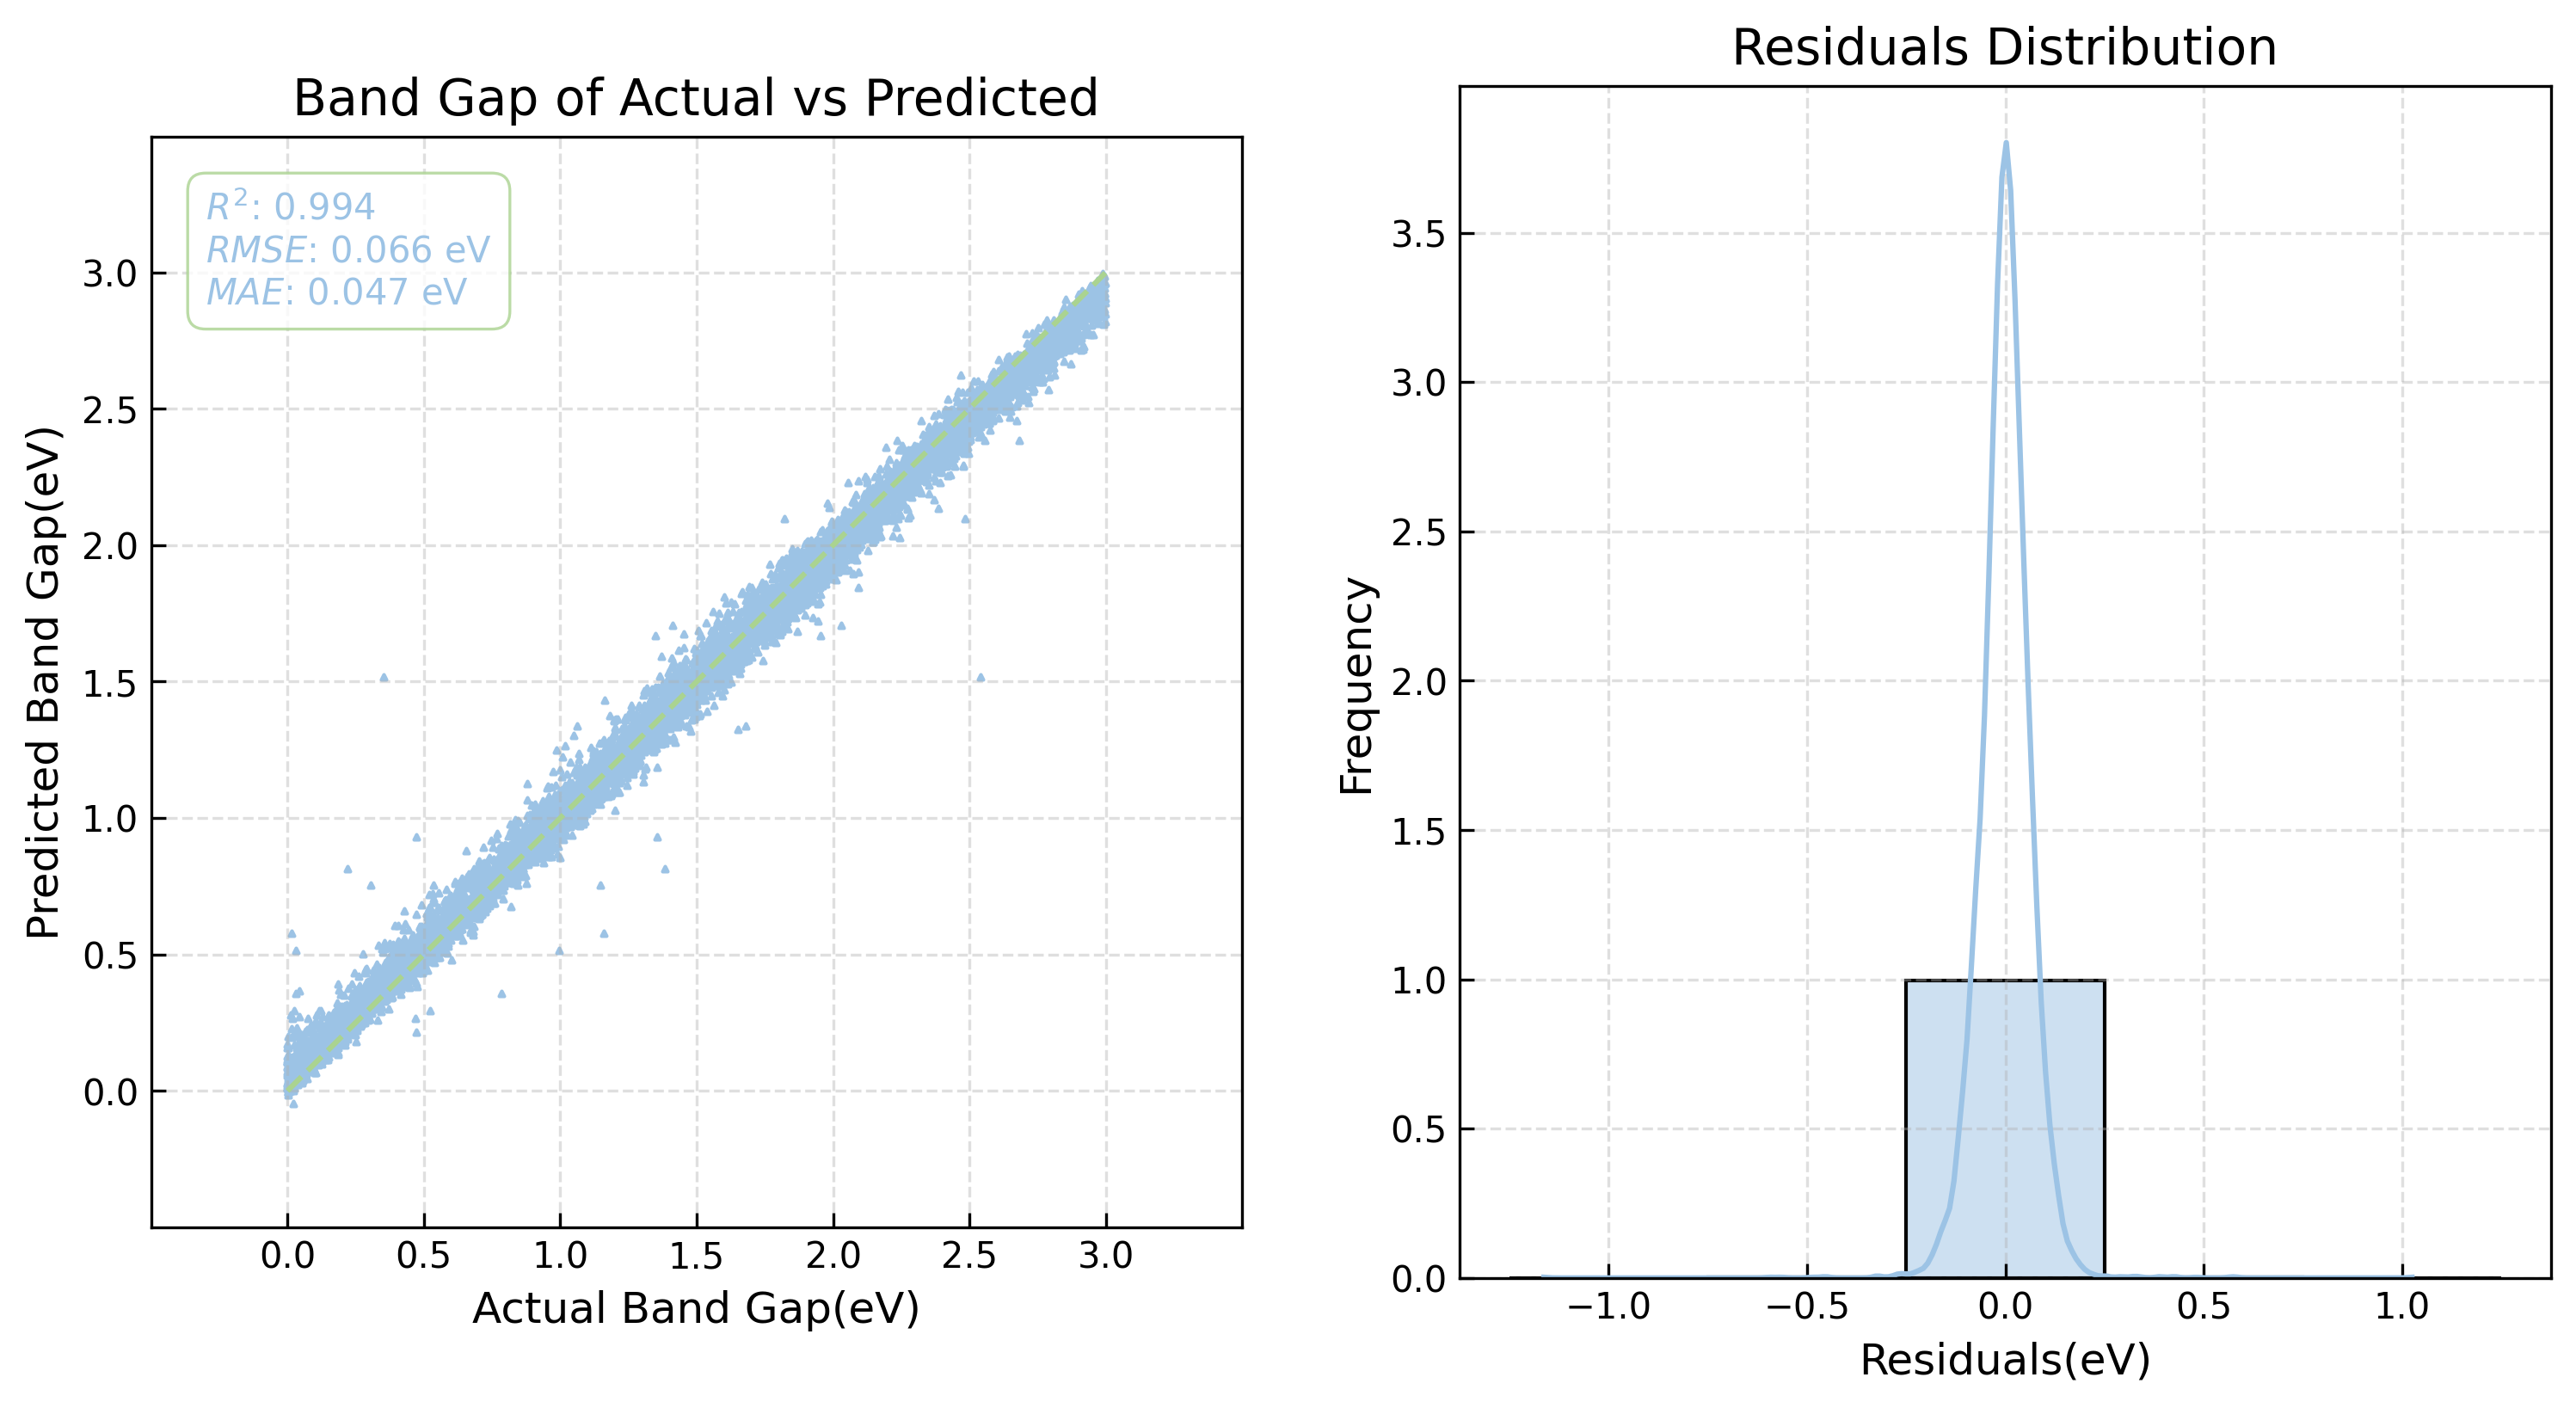


Model Evaluation Results:
Test set size: 8275
Test set: R²: 0.9940 RMSE: 0.0665 MAE: 0.0474 MAPE: 148.7706%
[Test Error] Evaluating DFT GBR on test set:


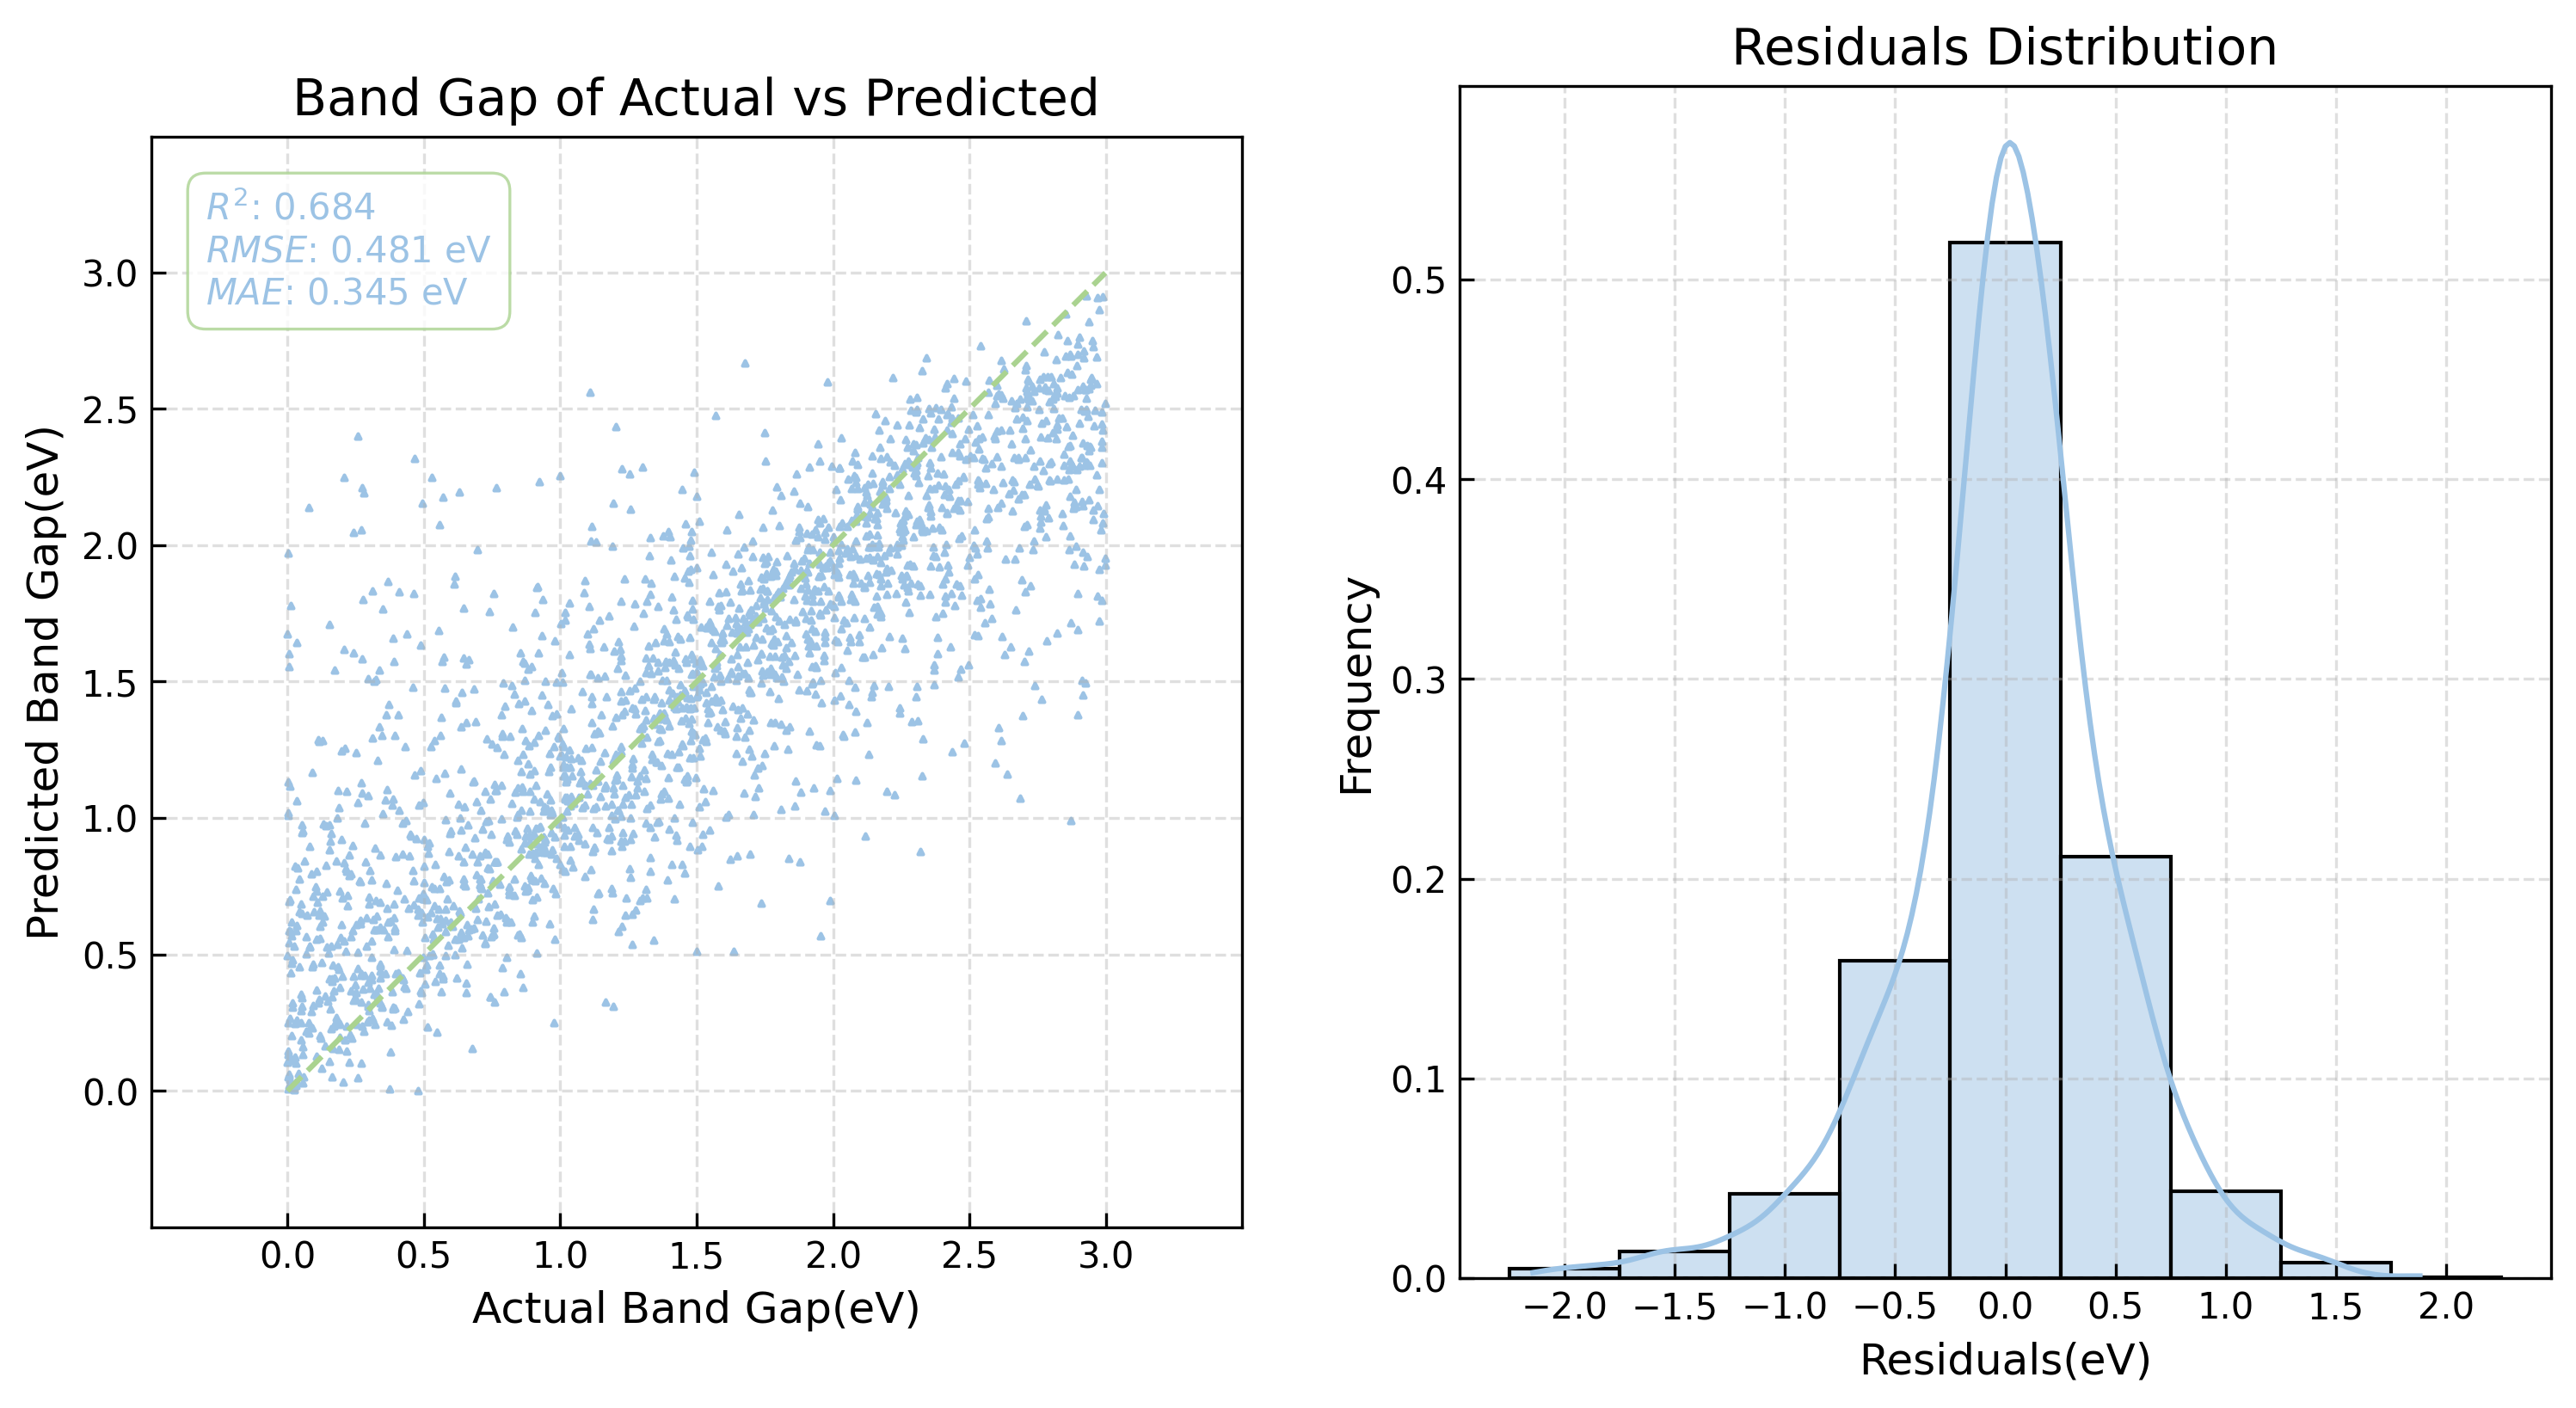


Model Evaluation Results:
Test set size: 2067
Test set: R²: 0.6844 RMSE: 0.4809 MAE: 0.3454 MAPE: 830.0933%


In [8]:
from sklearn.ensemble import GradientBoostingRegressor
MODEL_NAME = 'GBR'
best_gbr = GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=9, 
    max_features=0.25, subsample=1.0, random_state=RANDOM_SEED)
model = SingleModel(model=best_gbr)
model.train(dft_all_train_X, dft_all_train_y)
# evaluate on the dft train set
print(f"[Train Error] Evaluating DFT {MODEL_NAME} on train set:")
    
train_metrics = model.evaluate(dft_all_train_X, dft_all_train_y, fig_show=True)
# evaluate on the dft test set
print(f"[Test Error] Evaluating DFT {MODEL_NAME} on test set:")
test_metrics = model.evaluate(dft_test_X, dft_test_y, fig_show=True)

## 4. XGBoost

In [27]:
from xgboost import XGBRegressor
MODEL_NAME = 'XGBoost'

In [28]:
xgb_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'n_estimators', 'learning_rate', 'max_depth', 'colsample_bytree', 'R²', 'RMSE', 'MAE'])
# Define the hyperparameter search space
import itertools

params = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 6, 7, 10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0]
}
n_iter = 200
scaler = StandardScaler()
scaled_dft_train_X = scaler.fit_transform(dft_train_X)
scaled_dft_val_X = scaler.transform(dft_val_X)

# 生成所有可能的参数组合
all_params = list(itertools.product(
    params['n_estimators'],
    params['max_depth'],
    params['learning_rate'],
    params['colsample_bytree']
))

# 随机选择 n_iter 个组合
if n_iter > len(all_params):
    sampled_params_list = all_params
    print(f"Warning: n_iter is larger than the number of all possible combinations. Using all {len(all_params)} combinations.")
else:
    sampled_params_list = random.sample(all_params, n_iter)

for i, sampled_params_tuple in enumerate(sampled_params_list):
    sampled_params = {
        'n_estimators': sampled_params_tuple[0],
        'max_depth': sampled_params_tuple[1],
        'learning_rate': sampled_params_tuple[2],
        'colsample_bytree': sampled_params_tuple[3]
    }

    print(f"[Iter {i+1}/{len(sampled_params_list)}] Sampled parameters: {sampled_params}")

    # Create the model with sampled parameters  
    model = XGBRegressor(
        n_estimators=sampled_params['n_estimators'],
        max_depth=sampled_params['max_depth'],
        learning_rate=sampled_params['learning_rate'],
        colsample_bytree=sampled_params['colsample_bytree'],
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    # fit the model
    model.fit(scaled_dft_train_X, dft_train_y)
    # Predict
    train_pred = model.predict(scaled_dft_train_X)
    val_pred = model.predict(scaled_dft_val_X)
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(dft_train_y, train_pred))
    val_rmse = np.sqrt(mean_squared_error(dft_val_y, val_pred))
    train_r2 = r2_score(dft_train_y, train_pred)
    val_r2 = r2_score(dft_val_y, val_pred)
    train_mae = mean_absolute_error(dft_train_y, train_pred)
    val_mae = mean_absolute_error(dft_val_y, val_pred)

    # Append metrics to DataFrame
    xgb_metrics.loc[len(xgb_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Train',
        'n_estimators': sampled_params['n_estimators'],
        'max_depth': sampled_params['max_depth'],
        'learning_rate': sampled_params['learning_rate'],
        'colsample_bytree': sampled_params['colsample_bytree'],
        'R²': train_r2,
        'RMSE': train_rmse,
        'MAE': train_mae
    }
    xgb_metrics.loc[len(xgb_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Validation',
        'n_estimators': sampled_params['n_estimators'],
        'max_depth': sampled_params['max_depth'],
        'learning_rate': sampled_params['learning_rate'],
        'colsample_bytree': sampled_params['colsample_bytree'],
        'R²': val_r2,
        'RMSE': val_rmse,
        'MAE': val_mae
    }
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

# 输出最优参数
best_val_index = xgb_metrics[xgb_metrics['Error_Type'] == 'Validation']['RMSE'].idxmin()
best_val_params = xgb_metrics.iloc[best_val_index]
print(f"Best Validation Parameters: {best_val_params['n_estimators']}, {best_val_params['max_depth']}, {best_val_params['learning_rate']}, {best_val_params['colsample_bytree']}")  
print(f"Best Validation RMSE: {best_val_params['RMSE']}")
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
xgb_metrics.sort_values(by=['Error_Type', 'RMSE'], ascending=[False, True], inplace=True) # Sort inplace
xgb_metrics.reset_index(drop=True, inplace=True) # Reset index inplace
xgb_metrics.to_csv(os.path.join(hp_path, f'{MODEL_NAME}_metrics.csv'), index=False)

[Iter 1/200] Sampled parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


KeyboardInterrupt: 

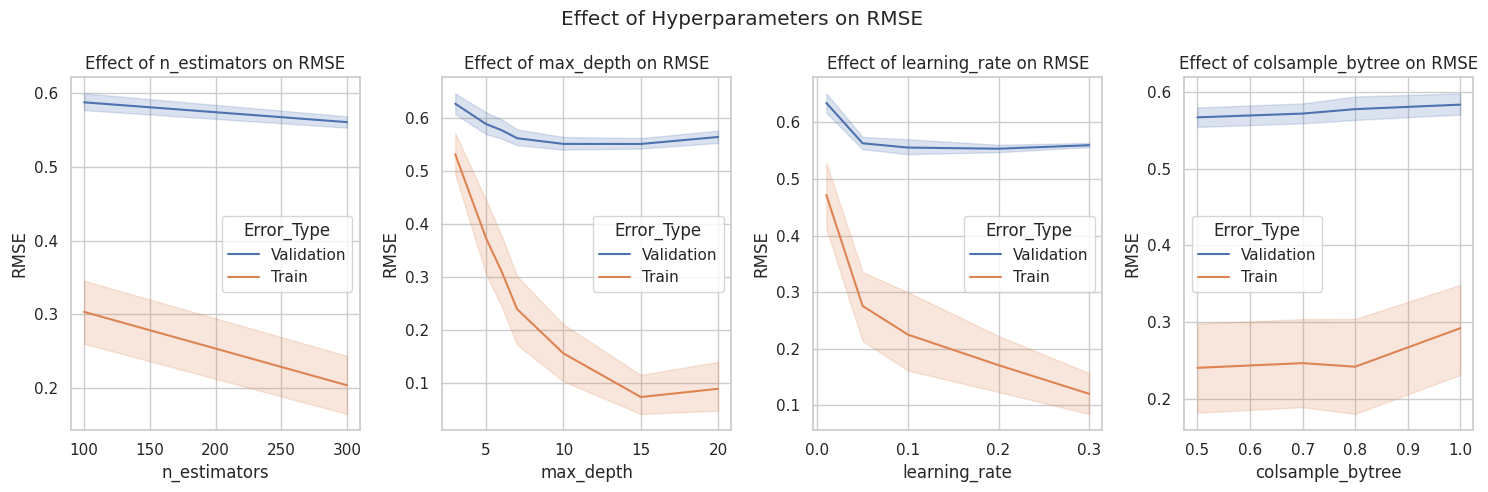

In [ ]:
# 绘制超参数搜索结果图，多幅图，每幅图展示一个超参数对模型性能的影响
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.lineplot(data=xgb_metrics, x='n_estimators', y='RMSE', hue='Error_Type')
plt.title('Effect of n_estimators on RMSE')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.subplot(1, 4, 2)
sns.lineplot(data=xgb_metrics, x='max_depth', y='RMSE', hue='Error_Type')
plt.title('Effect of max_depth on RMSE')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.subplot(1, 4, 3)
sns.lineplot(data=xgb_metrics, x='learning_rate', y='RMSE', hue='Error_Type')
plt.title('Effect of learning_rate on RMSE')
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.subplot(1, 4, 4)
sns.lineplot(data=xgb_metrics, x='colsample_bytree', y='RMSE', hue='Error_Type')
plt.title('Effect of colsample_bytree on RMSE')
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')

plt.suptitle('Effect of Hyperparameters on RMSE')
plt.tight_layout()
plt.show()

### Test

In [ ]:
best_xgb = XGBRegressor(
    n_estimators=best_val_params['n_estimators'],
    max_depth=best_val_params['max_depth'],
    learning_rate=best_val_params['learning_rate'],
    colsample_bytree=best_val_params['colsample_bytree'],
    random_state=RANDOM_SEED,
    n_jobs=-1
)

model = SingleModel(model=best_xgb)
model.train(dft_all_train_X, dft_all_train_y)
# evaluate on the dft train set
print(f"[Train Error] Evaluating DFT {MODEL_NAME} on train set:")
    
train_metrics = model.evaluate(dft_all_train_X, dft_all_train_y, fig_show=True)
# evaluate on the dft test set
print(f"[Test Error] Evaluating DFT {MODEL_NAME} on test set:")
test_metrics = model.evaluate(dft_test_X, dft_test_y, fig_show=True)

Starting model training...


TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '(GradientBoostingRegressor(learning_rate=0.05, max_depth=7, max_features=0.25,
                          n_estimators=500, random_state=42),)' (type <class 'tuple'>) doesn't

## 5. Ridge

In [ ]:
from sklearn.linear_model import Ridge
# Define the model
MODEL_NAME = 'Ridge'

In [ ]:
ridge_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'alpha', 'R²', 'RMSE', 'MAE'])
# Define the hyperparameter search space
import itertools

params = {
    'alpha': list(np.arange(0.01, 10.01, 0.01)), 
}
n_iter = len(params['alpha'])  # Number of iterations
scaler = StandardScaler()
scaled_dft_train_X = scaler.fit_transform(dft_train_X)
scaled_dft_val_X = scaler.transform(dft_val_X)

# 生成所有可能的参数组合
all_params = list(itertools.product(
    params['alpha']
))

# 随机选择 n_iter 个组合
if n_iter > len(all_params):
    sampled_params_list = all_params
    print(f"Warning: n_iter is larger than the number of all possible combinations. Using all {len(all_params)} combinations.")
else:
    sampled_params_list = random.sample(all_params, n_iter)

for i, sampled_params_tuple in enumerate(sampled_params_list):
    sampled_params = {
        'alpha': sampled_params_tuple[0],
    }

    print(f"[Iter {i+1}/{len(sampled_params_list)}] Sampled parameters: {sampled_params}")

    # Create the model with sampled parameters  
    model = Ridge(alpha=sampled_params['alpha'], random_state=RANDOM_SEED)
    # fit the model
    model.fit(scaled_dft_train_X, dft_train_y)
    # Predict
    train_pred = model.predict(scaled_dft_train_X)
    val_pred = model.predict(scaled_dft_val_X)
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(dft_train_y, train_pred))
    val_rmse = np.sqrt(mean_squared_error(dft_val_y, val_pred))
    train_r2 = r2_score(dft_train_y, train_pred)
    val_r2 = r2_score(dft_val_y, val_pred)
    train_mae = mean_absolute_error(dft_train_y, train_pred)
    val_mae = mean_absolute_error(dft_val_y, val_pred)

    # Append metrics to DataFrame
    ridge_metrics.loc[len(ridge_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Train',
        'alpha': sampled_params['alpha'],
        'R²': train_r2,
        'RMSE': train_rmse,
        'MAE': train_mae
    }
    ridge_metrics.loc[len(ridge_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Validation',
        'alpha': sampled_params['alpha'],
        'R²': val_r2,
        'RMSE': val_rmse,
        'MAE': val_mae
    }
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

# 输出最优参数
best_val_index = ridge_metrics[ridge_metrics['Error_Type'] == 'Validation']['RMSE'].idxmin()
best_val_params = ridge_metrics.iloc[best_val_index]
print(f"Best Validation Parameters: {best_val_params['alpha']}")
print(f"Best Validation RMSE: {best_val_params['RMSE']}")
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
ridge_metrics.sort_values(by=['Error_Type', 'RMSE'], ascending=[False, True], inplace=True) # Sort inplace
ridge_metrics.reset_index(drop=True, inplace=True) # Reset index inplace
ridge_metrics.to_csv(os.path.join(hp_path, f'{MODEL_NAME}_metrics.csv'), index=False)

[Iter 1/1000] Sampled parameters: {'alpha': np.float64(8.5)}
Train RMSE: 0.704262093195401, Validation RMSE: 0.7155998169729532
[Iter 2/1000] Sampled parameters: {'alpha': np.float64(7.84)}
Train RMSE: 0.7042476701787684, Validation RMSE: 0.715587468957361
[Iter 3/1000] Sampled parameters: {'alpha': np.float64(5.68)}
Train RMSE: 0.7042045577114586, Validation RMSE: 0.7155525279916037
[Iter 4/1000] Sampled parameters: {'alpha': np.float64(2.13)}
Train RMSE: 0.7041539049247487, Validation RMSE: 0.7155211589315342
[Iter 5/1000] Sampled parameters: {'alpha': np.float64(6.01)}
Train RMSE: 0.7042106768083193, Validation RMSE: 0.7155572495830875
[Iter 6/1000] Sampled parameters: {'alpha': np.float64(2.2199999999999998)}
Train RMSE: 0.7041547554179277, Validation RMSE: 0.7155214079181322
[Iter 7/1000] Sampled parameters: {'alpha': np.float64(8.33)}
Train RMSE: 0.7042583303989587, Validation RMSE: 0.7155965713983784
[Iter 8/1000] Sampled parameters: {'alpha': np.float64(8.91)}
Train RMSE: 0.704

Train RMSE: 0.7041474581447014, Validation RMSE: 0.7155205949505855
[Iter 42/1000] Sampled parameters: {'alpha': np.float64(7.6)}
Train RMSE: 0.7042425546397589, Validation RMSE: 0.7155831537670386
[Iter 43/1000] Sampled parameters: {'alpha': np.float64(4.32)}
Train RMSE: 0.7041815283928659, Validation RMSE: 0.7155359038316567
[Iter 44/1000] Sampled parameters: {'alpha': np.float64(5.39)}
Train RMSE: 0.7041993405949453, Validation RMSE: 0.7155485874350697
[Iter 45/1000] Sampled parameters: {'alpha': np.float64(1.17)}
Train RMSE: 0.704146693459562, Validation RMSE: 0.7155208094465354
[Iter 46/1000] Sampled parameters: {'alpha': np.float64(7.64)}
Train RMSE: 0.7042434022056293, Validation RMSE: 0.7155838661967653
[Iter 47/1000] Sampled parameters: {'alpha': np.float64(0.66)}
Train RMSE: 0.7041444021510989, Validation RMSE: 0.7155225224057914
[Iter 48/1000] Sampled parameters: {'alpha': np.float64(4.88)}
Train RMSE: 0.7041905548328283, Validation RMSE: 0.7155421614220755
[Iter 49/1000] Sa

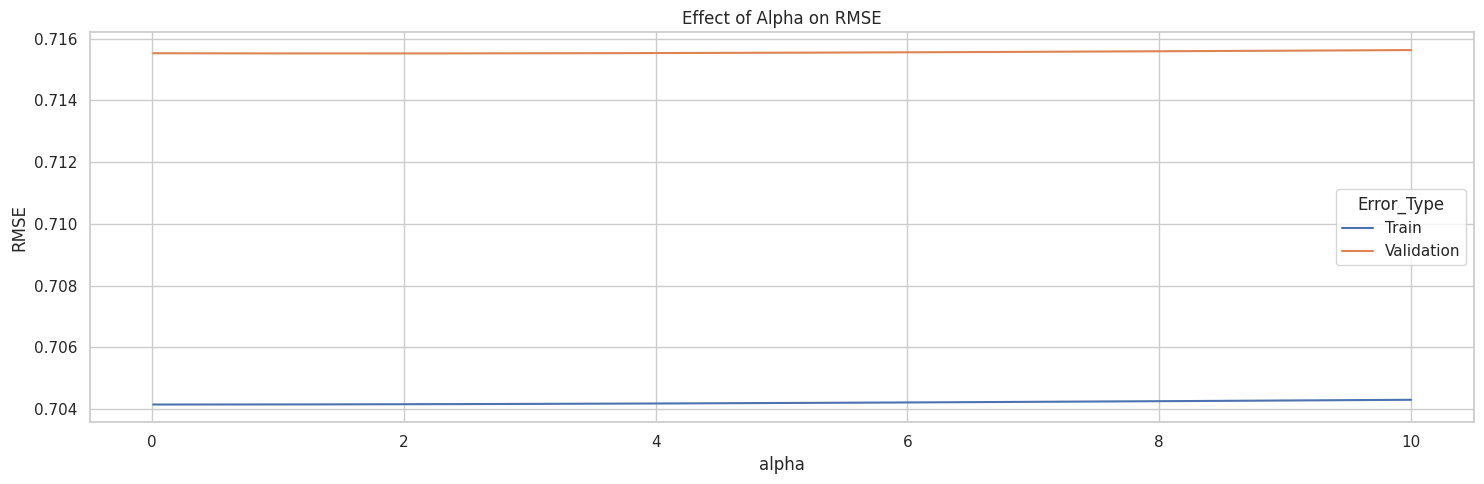

In [ ]:
# 绘制超参数搜索结果图，多幅图，每幅图展示一个超参数对模型性能的影响
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
sns.lineplot(data=ridge_metrics, x='alpha', y='RMSE', hue='Error_Type')
plt.title('Effect of Alpha on RMSE')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

### Test

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train Error] Evaluating DFT Ridge on train set:


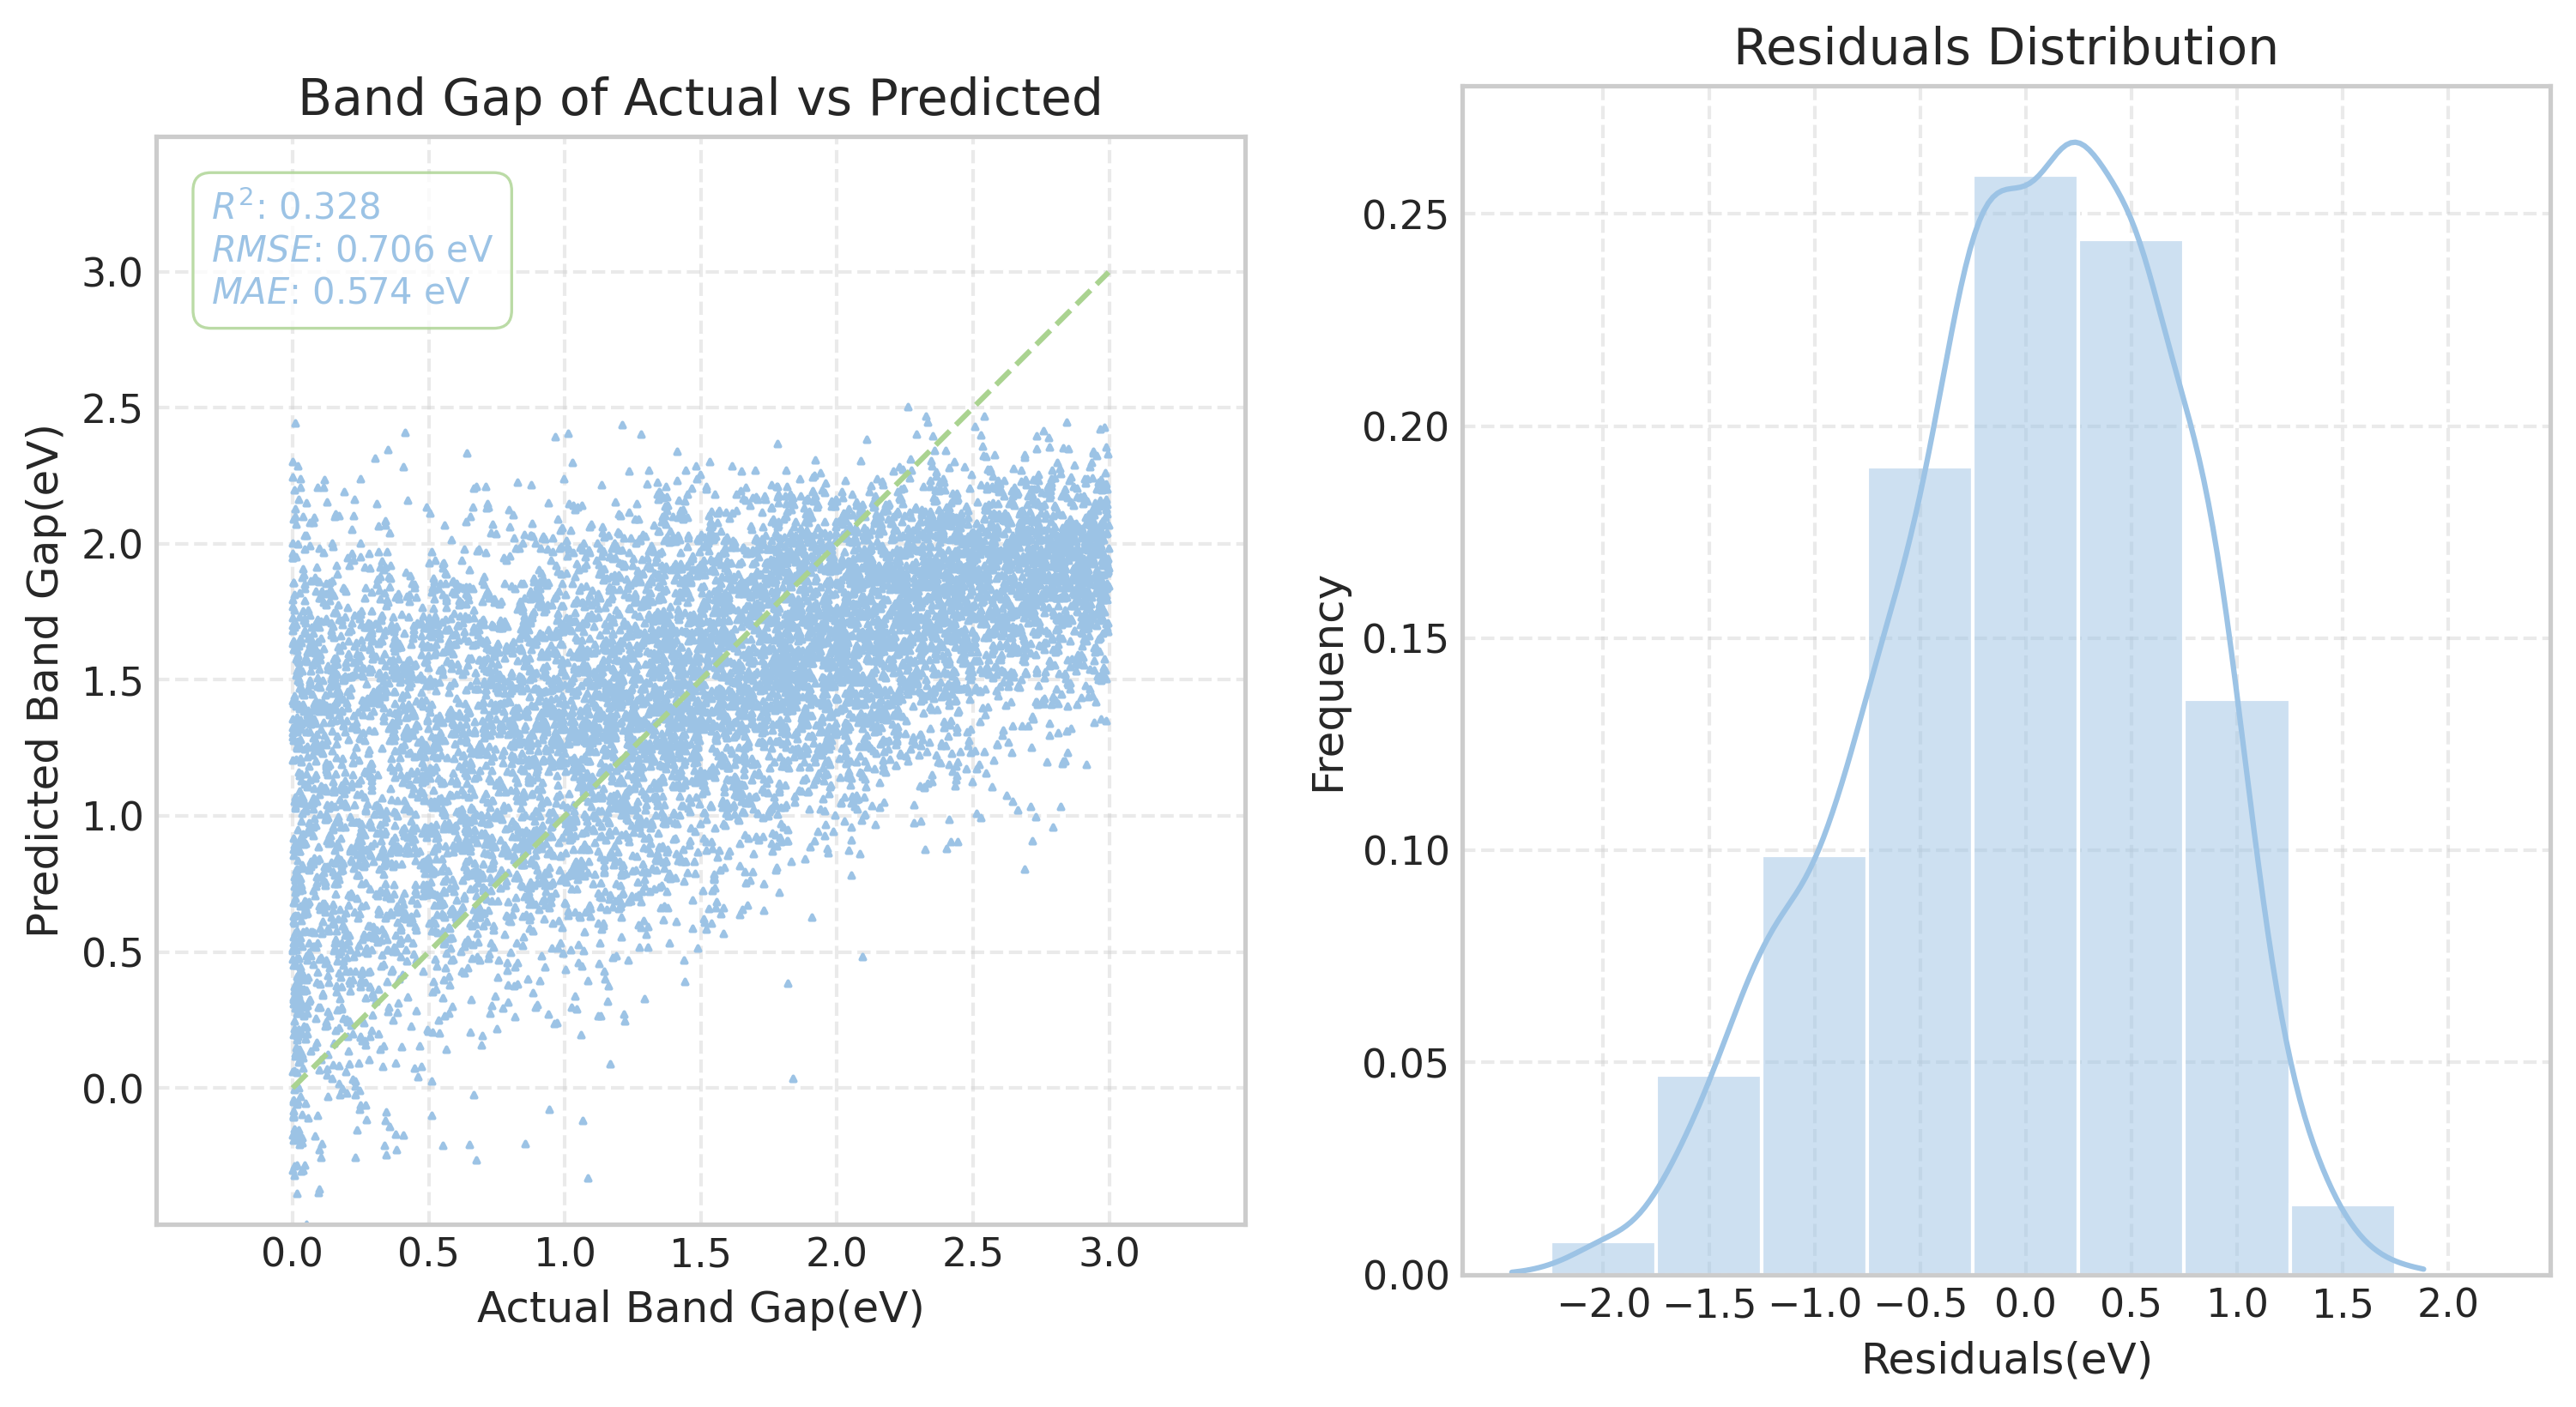


Model Evaluation Results:
Test set size: 8275
Test set: R²: 0.3284 RMSE: 0.7058 MAE: 0.5736 MAPE: 2501.5815%
[Test Error] Evaluating DFT Ridge on test set:


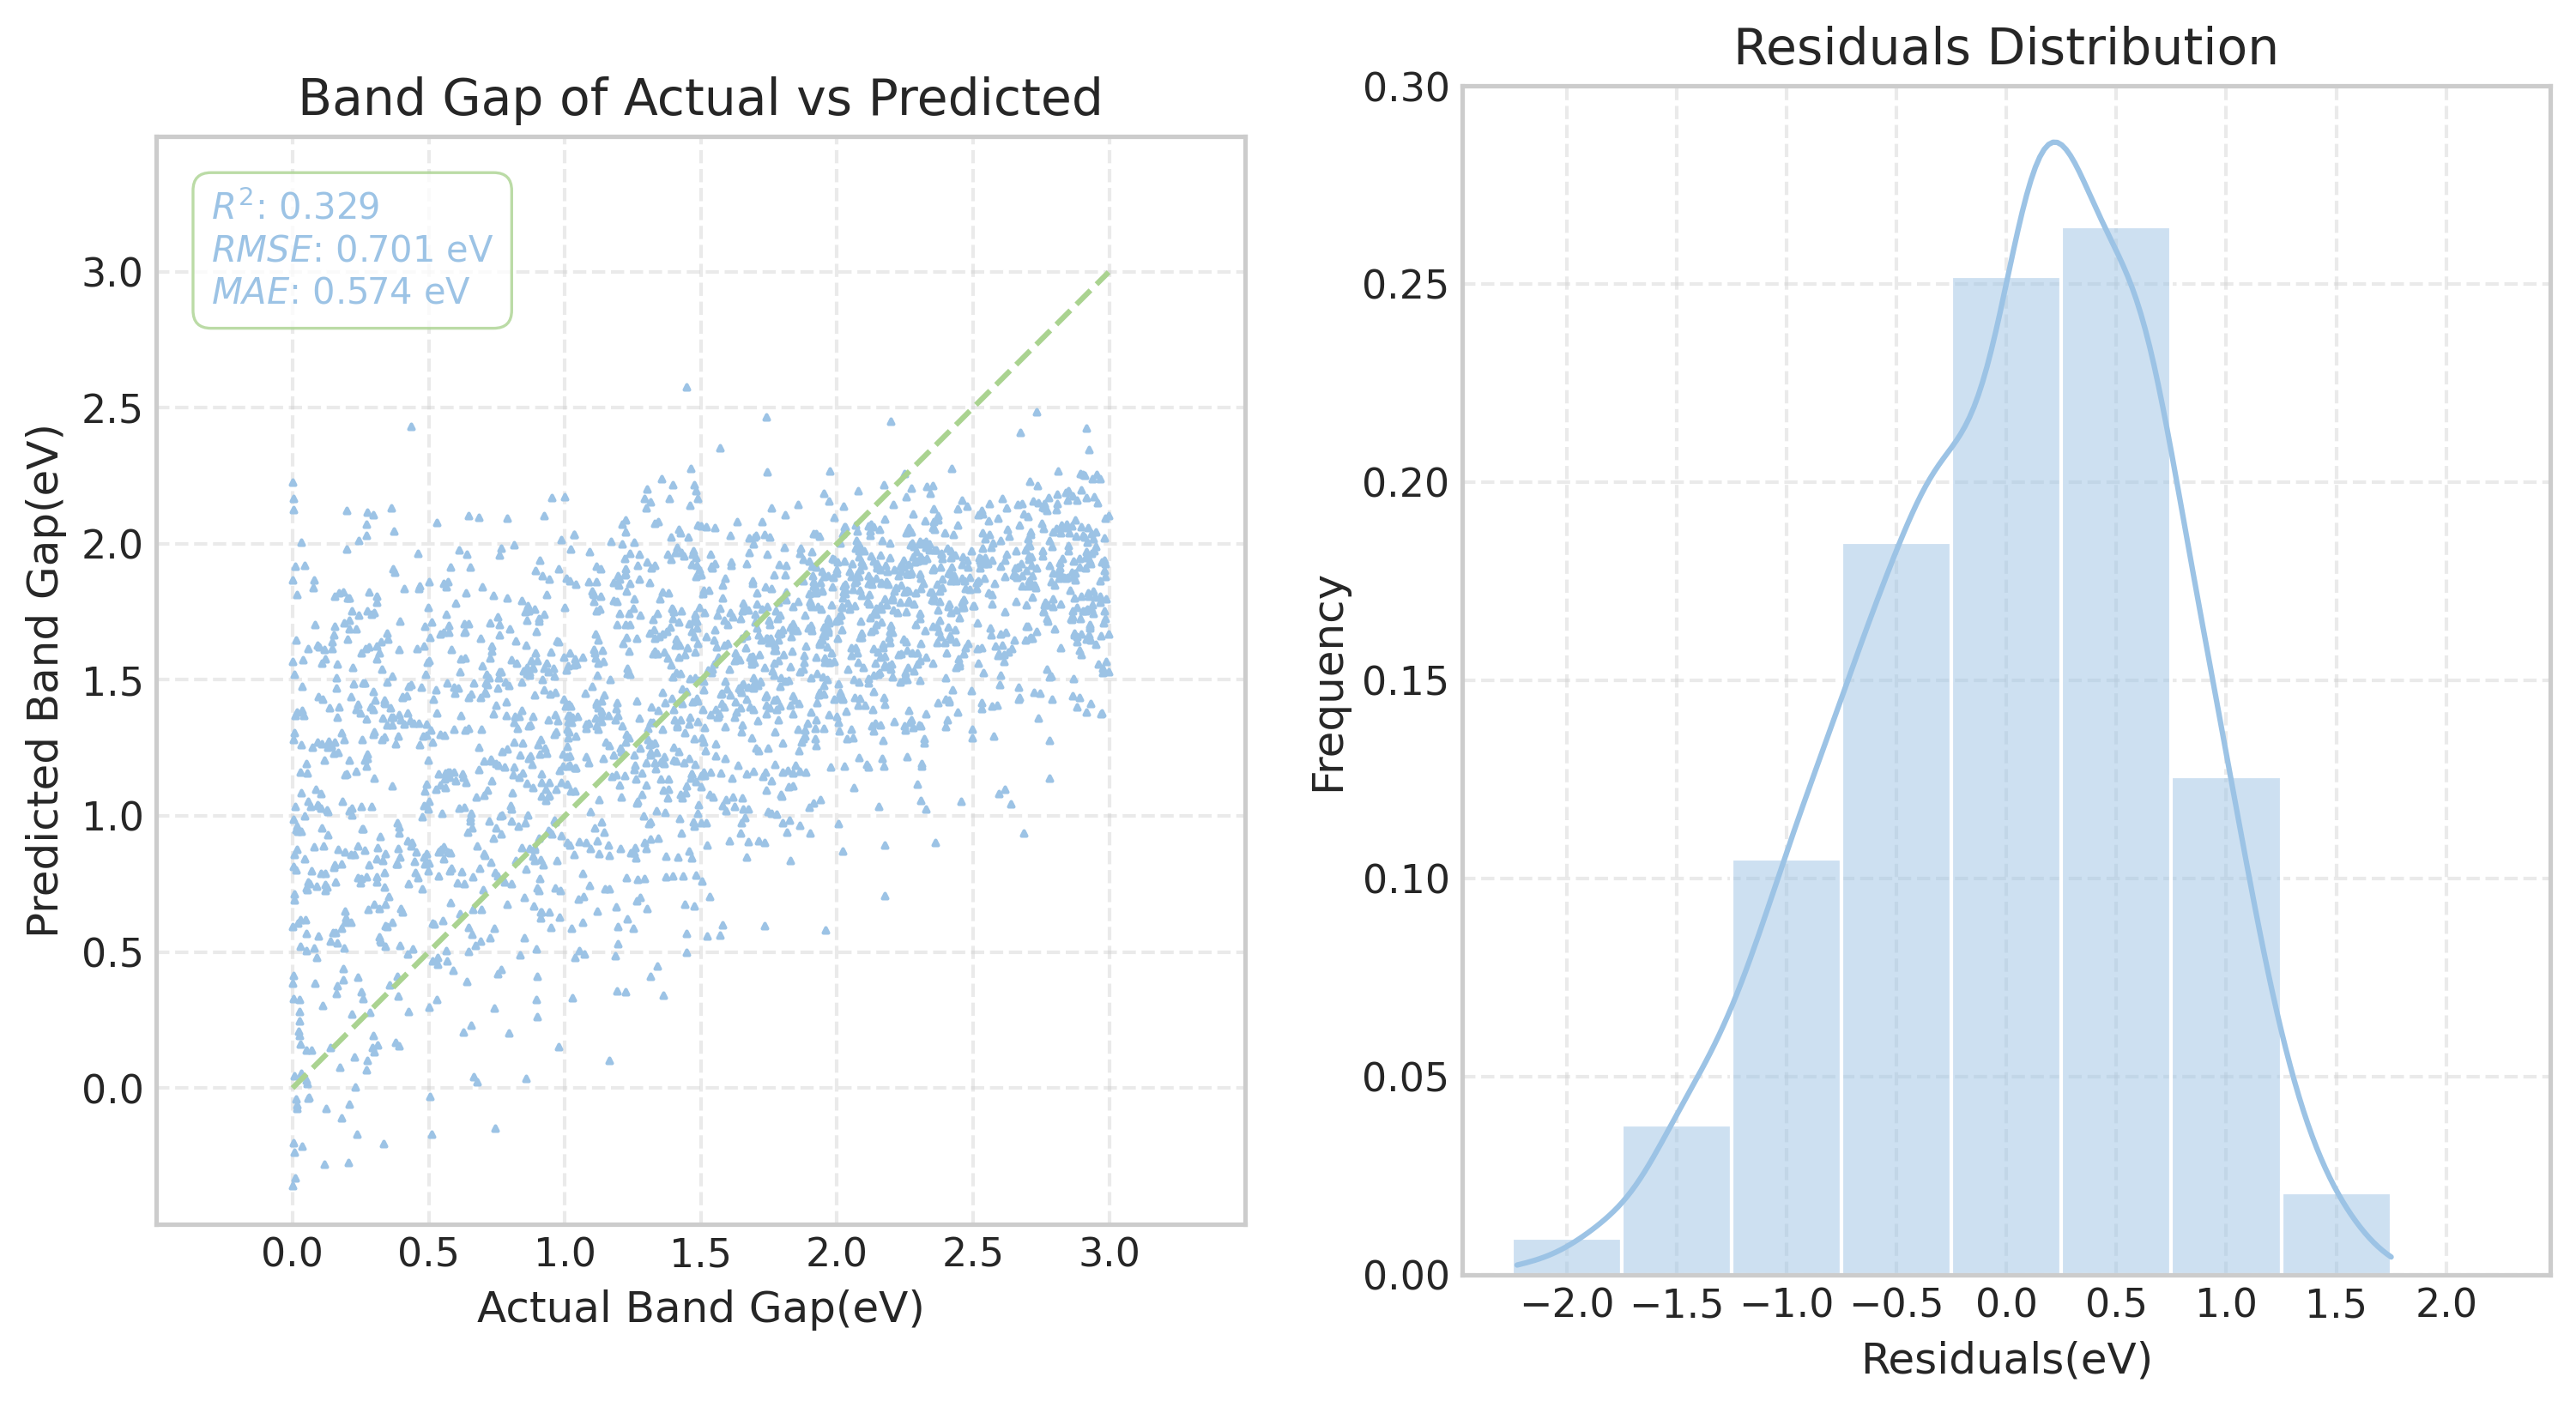


Model Evaluation Results:
Test set size: 2067
Test set: R²: 0.3291 RMSE: 0.7011 MAE: 0.5741 MAPE: 1148.4563%


In [ ]:
best_ridge = Ridge(alpha=best_val_params['alpha'], random_state=RANDOM_SEED)
model = SingleModel(model=best_ridge)
model.train(dft_all_train_X, dft_all_train_y)
# evaluate on the dft train set
print(f"[Train Error] Evaluating DFT {MODEL_NAME} on train set:")
    
train_metrics = model.evaluate(dft_all_train_X, dft_all_train_y, fig_show=True)
# evaluate on the dft test set
print(f"[Test Error] Evaluating DFT {MODEL_NAME} on test set:")
test_metrics = model.evaluate(dft_test_X, dft_test_y, fig_show=True)

## 6. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Define the model
MODEL_NAME = 'Random Forest'

In [ ]:
rf_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'n_estimators', 'max_depth', 'max_features', 'R²', 'RMSE', 'MAE'])
# Define the hyperparameter search space
import itertools

params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 7, 10, 15, 20],
    'max_features': [0.5, 0.75, 1.0, 'sqrt', 'log2']
}
n_iter = 50
scaler = StandardScaler()
scaled_dft_train_X = scaler.fit_transform(dft_train_X)
scaled_dft_val_X = scaler.transform(dft_val_X)

# 生成所有可能的参数组合
all_params = list(itertools.product(
    params['n_estimators'],
    params['max_depth'],
    params['max_features']
))

# 随机选择 n_iter 个组合
if n_iter > len(all_params):
    sampled_params_list = all_params
    print(f"Warning: n_iter is larger than the number of all possible combinations. Using all {len(all_params)} combinations.")
else:
    sampled_params_list = random.sample(all_params, n_iter)

for i, sampled_params_tuple in enumerate(sampled_params_list):
    sampled_params = {
        'n_estimators': sampled_params_tuple[0],
        'max_depth': sampled_params_tuple[1],
        'max_features': sampled_params_tuple[2]
    }

    print(f"[Iter {i+1}/{len(sampled_params_list)}] Sampled parameters: {sampled_params}")

    # Create the model with sampled parameters  
    model = RandomForestRegressor(
        n_estimators=sampled_params['n_estimators'],
        max_depth=sampled_params['max_depth'],
        max_features=sampled_params['max_features'],
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    # fit the model
    model.fit(scaled_dft_train_X, dft_train_y)
    # Predict
    train_pred = model.predict(scaled_dft_train_X)
    val_pred = model.predict(scaled_dft_val_X)
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(dft_train_y, train_pred))
    val_rmse = np.sqrt(mean_squared_error(dft_val_y, val_pred))
    train_r2 = r2_score(dft_train_y, train_pred)
    val_r2 = r2_score(dft_val_y, val_pred)
    train_mae = mean_absolute_error(dft_train_y, train_pred)
    val_mae = mean_absolute_error(dft_val_y, val_pred)

    # Append metrics to DataFrame
    rf_metrics.loc[len(rf_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Train',
        'n_estimators': sampled_params['n_estimators'],
        'max_depth': sampled_params['max_depth'],
        'max_features': sampled_params['max_features'],
        'R²': train_r2,
        'RMSE': train_rmse,
        'MAE': train_mae
    }
    rf_metrics.loc[len(rf_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Validation',
        'n_estimators': sampled_params['n_estimators'],
        'max_depth': sampled_params['max_depth'],
        'max_features': sampled_params['max_features'],
        'R²': val_r2,
        'RMSE': val_rmse,
        'MAE': val_mae
    }
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

# 输出最优参数
best_val_index = rf_metrics[rf_metrics['Error_Type'] == 'Validation']['RMSE'].idxmin()
best_val_params = rf_metrics.iloc[best_val_index]
print(f"Best Validation Parameters: {best_val_params['n_estimators']}, {best_val_params['max_depth']}, {best_val_params['max_features']}")
print(f"Best Validation RMSE: {best_val_params['RMSE']}")
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
rf_metrics.sort_values(by=['Error_Type', 'RMSE'], ascending=[False, True], inplace=True) # Sort inplace
rf_metrics.reset_index(drop=True, inplace=True) # Reset index inplace
rf_metrics.to_csv(os.path.join(hp_path, f'{MODEL_NAME}_metrics.csv'), index=False)

In [ ]:
rf_metrics

Model  Error_Type  n_estimators max_depth max_features        R²  \
65  Random Forest  Validation           300      None          0.5  0.637191   
13  Random Forest  Validation           300      None          1.0  0.636709   
25  Random Forest  Validation           300        20         0.75  0.635994   
45  Random Forest  Validation           100        20          0.5  0.630955   
61  Random Forest  Validation           300        20         sqrt  0.625506   
..            ...         ...           ...       ...          ...       ...   
92  Random Forest       Train           300         5          0.5  0.433276   
20  Random Forest       Train           100         5          0.5  0.432050   
54  Random Forest       Train           500         5         log2  0.390127   
22  Random Forest       Train           300         5         log2  0.389495   
82  Random Forest       Train           100         5         log2  0.387053   

        RMSE       MAE  
65  0.516344  0.386176  
13  0.516687  0.385831  
25  0.517195  0.387917  
45  0.520763  0.390207  
61  0.524593  0.396307  
..       ...       ...  
92  0.642358  0.514340  
20  0.643052  0.515287  
54  0.666363  0.540944  
22  0.666708  0.541170  
82  0.668040  0.542126  

[100 rows x 8 columns]

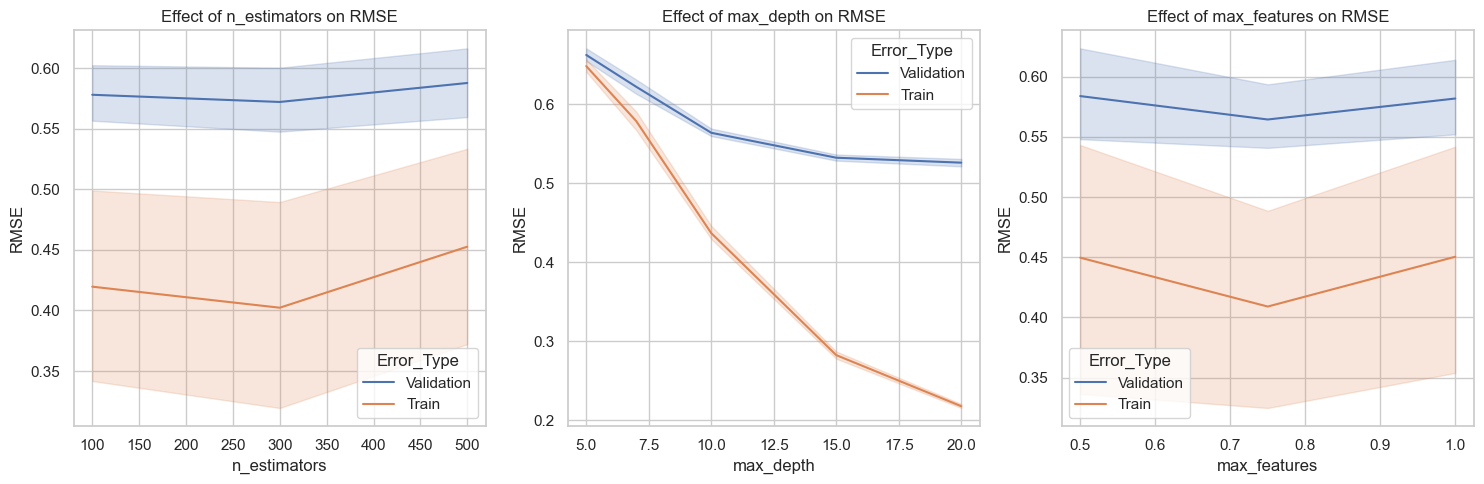

In [ ]:
# 绘制超参数搜索结果图，多幅图，每幅图展示一个超参数对模型性能的影响
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=rf_metrics, x='n_estimators', y='RMSE', hue='Error_Type')
plt.title('Effect of n_estimators on RMSE')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.subplot(1, 3, 2)
sns.lineplot(data=rf_metrics, x='max_depth', y='RMSE', hue='Error_Type')
plt.title('Effect of max_depth on RMSE')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.subplot(1, 3, 3)
sns.lineplot(data=rf_metrics[~rf_metrics['max_features'].isin(['sqrt', 'log2'])], x='max_features', y='RMSE', hue='Error_Type')
plt.title('Effect of max_features on RMSE')
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

### Test

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  27.6s
Model training completed!
[Train Error] Evaluating DFT Random Forest on train set:


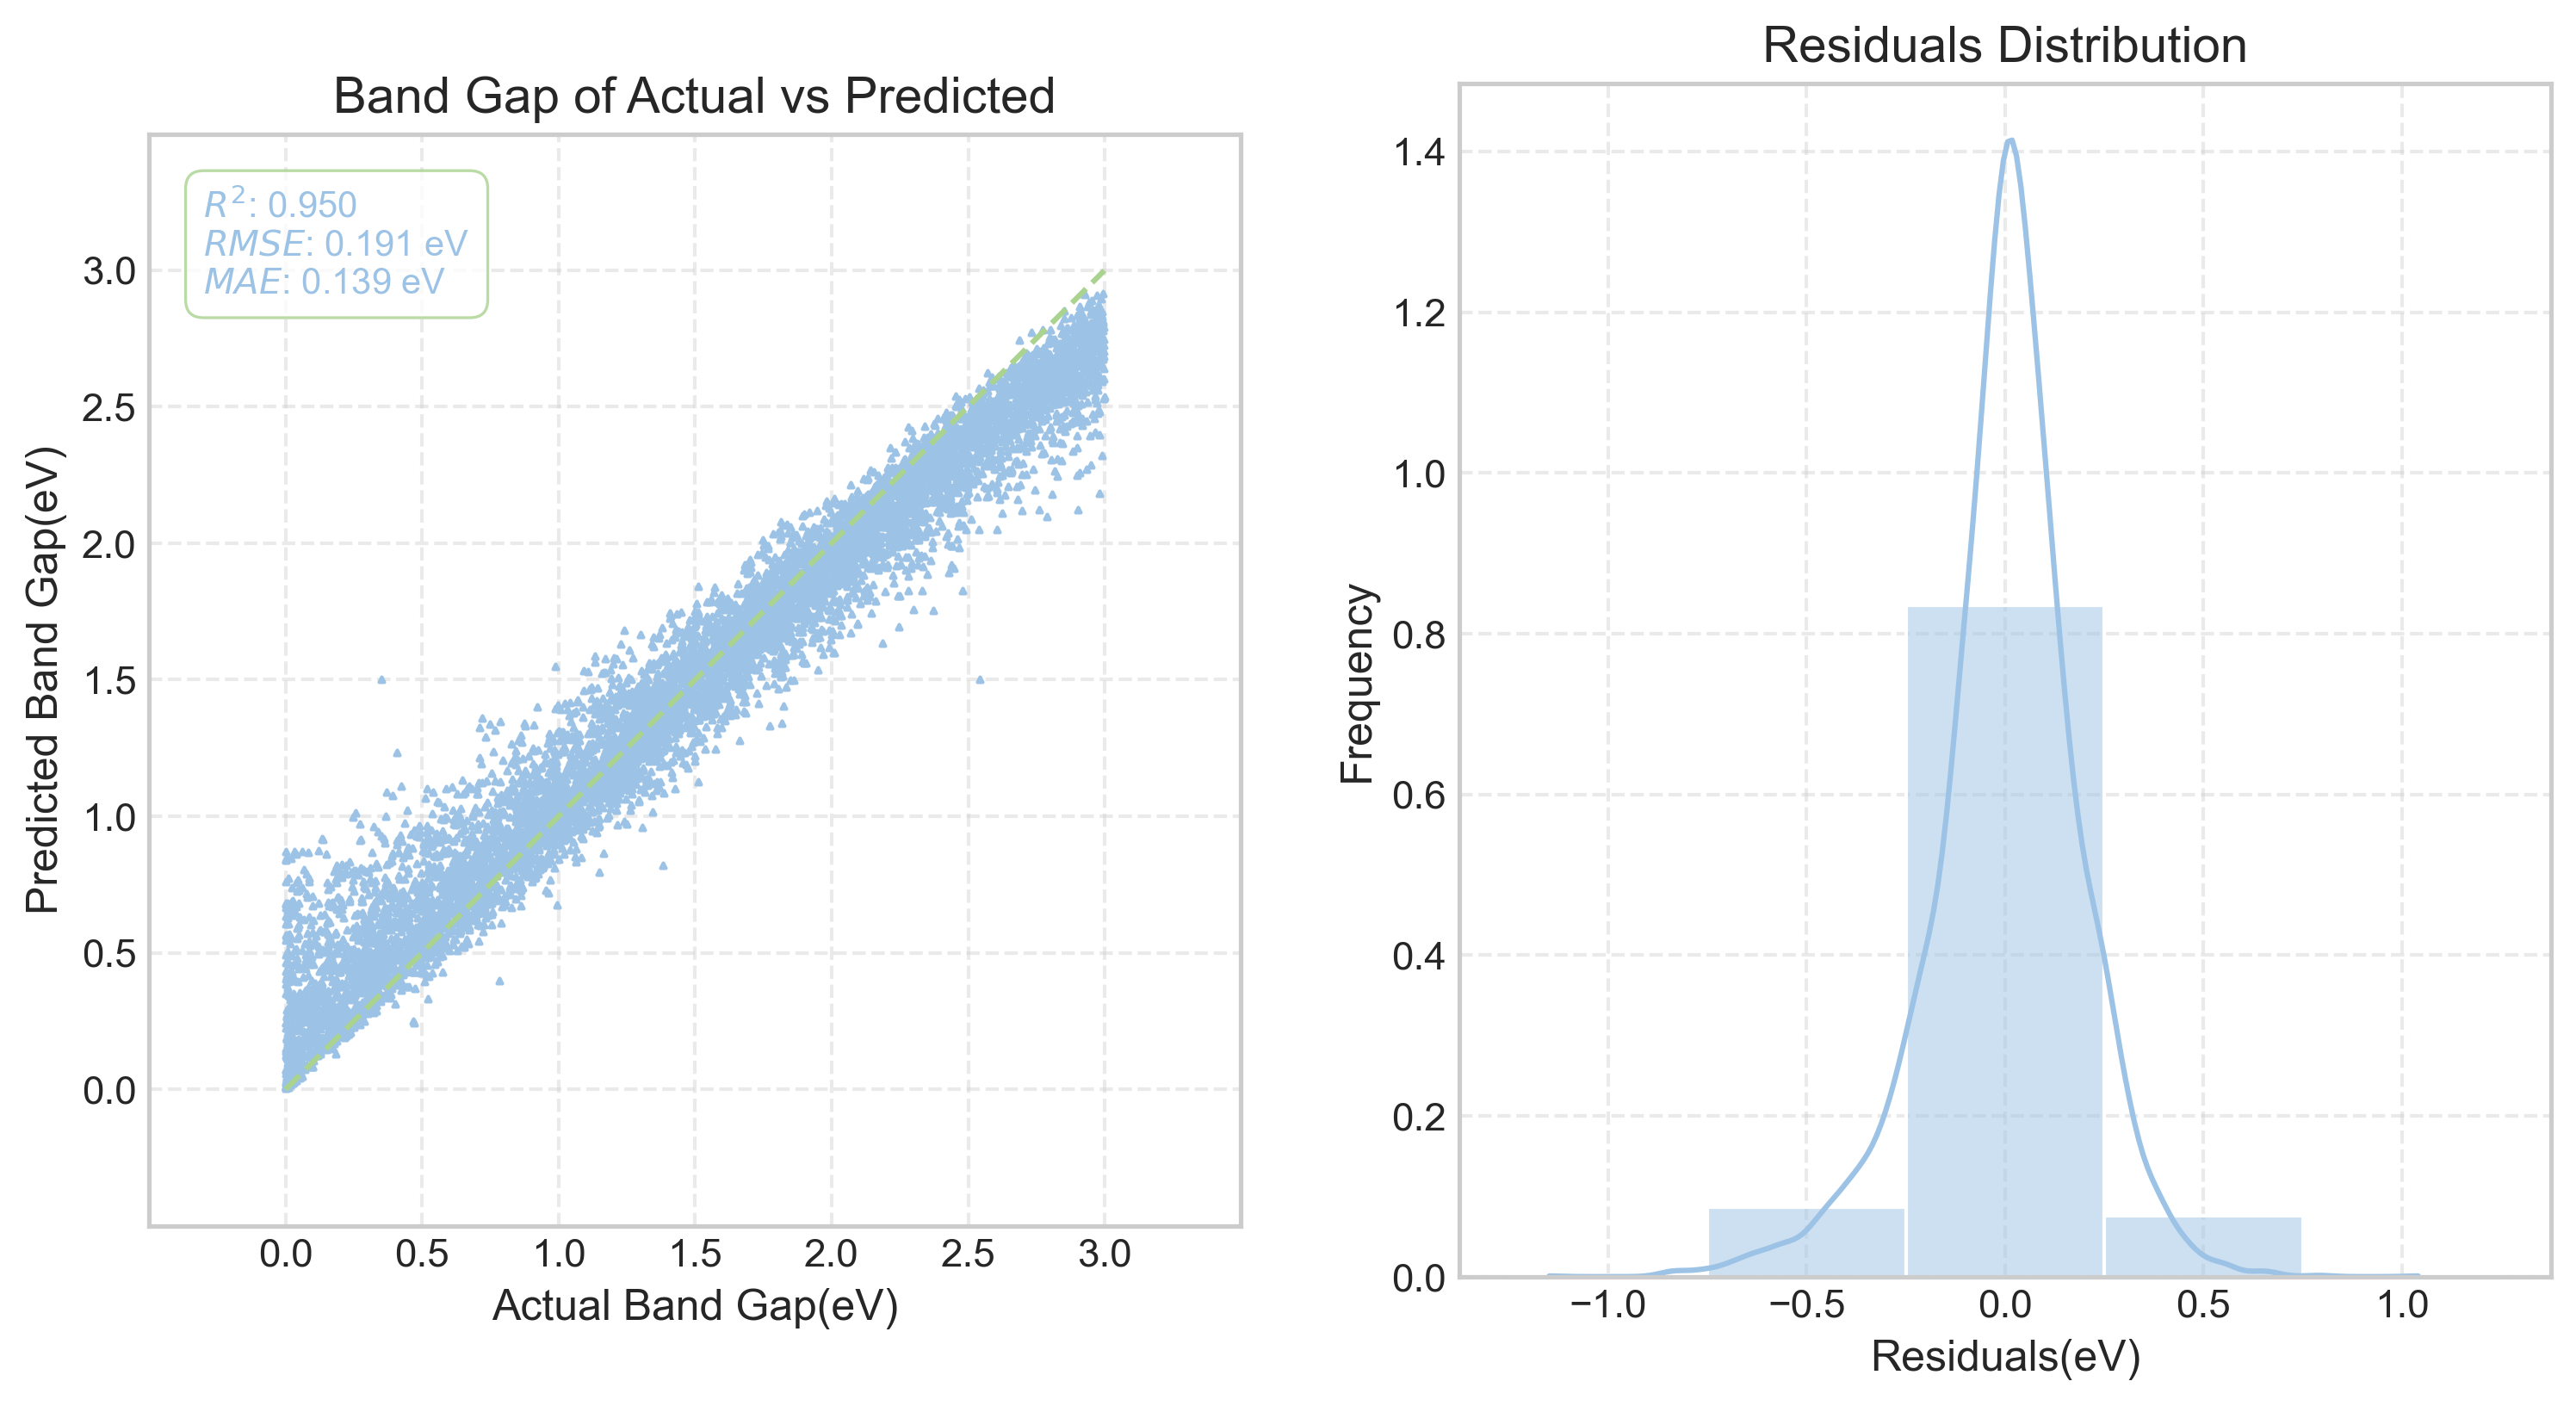


Model Evaluation Results:
Test set size: 7869
Test set: R²: 0.9502 RMSE: 0.1906 MAE: 0.1395 MAPE: 770.3050%
[Test Error] Evaluating DFT Random Forest on test set:


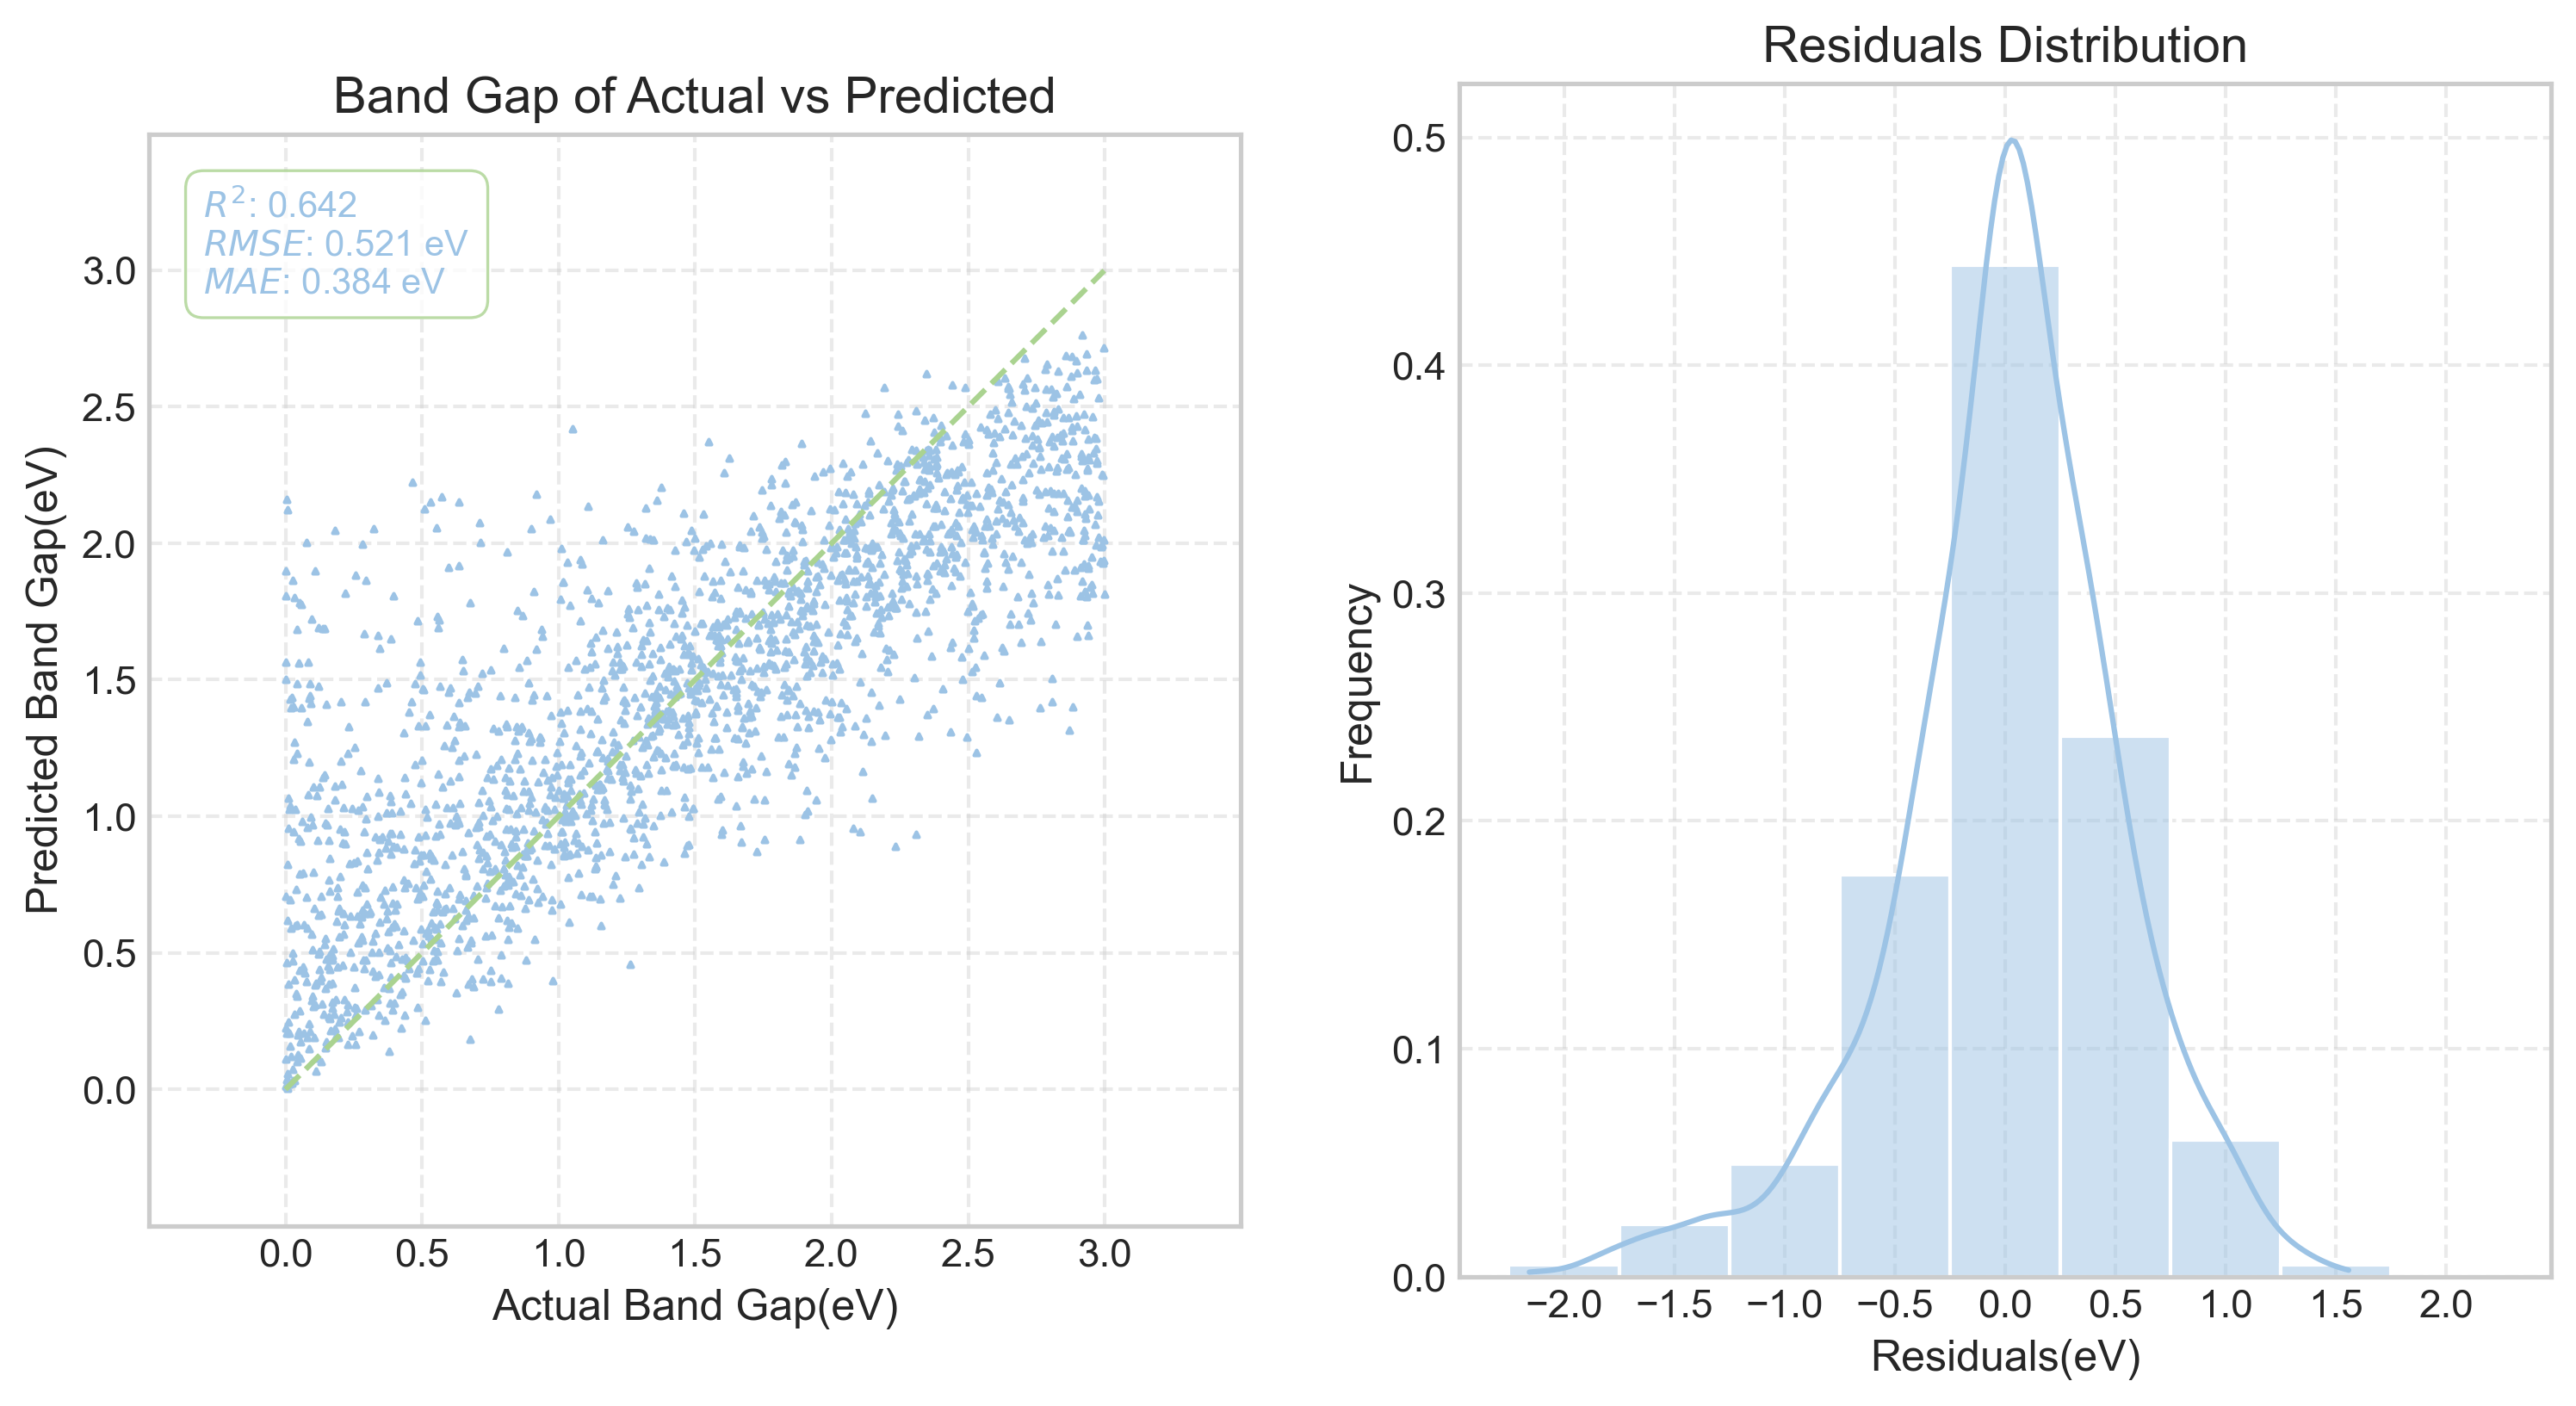


Model Evaluation Results:
Test set size: 1963
Test set: R²: 0.6416 RMSE: 0.5205 MAE: 0.3842 MAPE: 1643.1192%


In [ ]:
best_rf = RandomForestRegressor(
    n_estimators=best_val_params['n_estimators'], # 300
    max_depth=best_val_params['max_depth'],       # None
    max_features=0.75, # 0.5
    random_state=RANDOM_SEED,
    n_jobs=-1
)
model = SingleModel(model=best_rf)
model.train(dft_all_train_X, dft_all_train_y)
# evaluate on the dft train set
print(f"[Train Error] Evaluating DFT {MODEL_NAME} on train set:")
    
train_metrics = model.evaluate(dft_all_train_X, dft_all_train_y, fig_show=True)
# evaluate on the dft test set
print(f"[Test Error] Evaluating DFT {MODEL_NAME} on test set:")
test_metrics = model.evaluate(dft_test_X, dft_test_y, fig_show=True)

## 7. SVR

In [ ]:
# Define the model
MODEL_NAME = 'SVR'

In [ ]:
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'C', 'epsilon', 'gamma', 'R²', 'RMSE', 'MAE'])
# Define the hyperparameter search space
import itertools

params = {
    'C': [0.1, 1, 10, 25, 50, 75, 100],
    'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10],
    'epsilon': [0.01, 0.05, 0.07, 0.5, 0.1, 1],
}
n_iter = 50
scaler = StandardScaler()
scaled_dft_train_X = scaler.fit_transform(dft_train_X)
scaled_dft_val_X = scaler.transform(dft_val_X)

# 生成所有可能的参数组合
all_params = list(itertools.product(params['C'], params['gamma'], params['epsilon']))

# 随机选择 n_iter 个组合
if n_iter > len(all_params):
    sampled_params_list = all_params
    print(f"Warning: n_iter is larger than the number of all possible combinations. Using all {len(all_params)} combinations.")
else:
    sampled_params_list = random.sample(all_params, n_iter)

for i, sampled_params_tuple in enumerate(sampled_params_list):
    sampled_params = {
        'C': sampled_params_tuple[0],
        'gamma': sampled_params_tuple[1],
        'epsilon': sampled_params_tuple[2]
    }

    print(f"[Iter {i+1}/{len(sampled_params_list)}] Sampled parameters: {sampled_params}")

    # Create SVR
    model = SVR(kernel='rbf', C=sampled_params['C'], epsilon=sampled_params['epsilon'], gamma=sampled_params['gamma'])
    # fit the model
    model.fit(scaled_dft_train_X, dft_train_y)
    # Predict
    train_pred = model.predict(scaled_dft_train_X)
    val_pred = model.predict(scaled_dft_val_X)
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(dft_train_y, train_pred))
    val_rmse = np.sqrt(mean_squared_error(dft_val_y, val_pred))
    train_r2 = r2_score(dft_train_y, train_pred)
    val_r2 = r2_score(dft_val_y, val_pred)
    train_mae = mean_absolute_error(dft_train_y, train_pred)
    val_mae = mean_absolute_error(dft_val_y, val_pred)

    # Append metrics to DataFrame
    model_metrics.loc[len(model_metrics)] ={
        'Model': MODEL_NAME,
        'Error_Type': 'Train',
        'C': sampled_params['C'],
        'epsilon': sampled_params['epsilon'],
        'gamma': sampled_params['gamma'],
        'R²': train_r2,
        'RMSE': train_rmse,
        'MAE': train_mae
    }
    model_metrics.loc[len(model_metrics)] ={
        'Model': MODEL_NAME,
        'Error_Type': 'Validation',
        'C': sampled_params['C'],
        'epsilon': sampled_params['epsilon'],
        'gamma': sampled_params['gamma'],
        'R²': val_r2,
        'RMSE': val_rmse,
        'MAE': val_mae
    }
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

# 输出最优参数
best_val_index = model_metrics[model_metrics['Error_Type'] == 'Validation']['RMSE'].idxmin()
best_val_params = model_metrics.iloc[best_val_index]
print(f"Best Validation Parameters: C={best_val_params['C']}, epsilon={best_val_params['epsilon']}, gamma={best_val_params['gamma']}")
print(f"Best Validation RMSE: {best_val_params['RMSE']}")

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
model_metrics.sort_values(by=['Error_Type', 'RMSE'], ascending=[False, True], inplace=True) # Sort inplace
model_metrics.reset_index(drop=True, inplace=True) # Reset index inplace
model_metrics.to_csv(os.path.join(hp_path, f'{MODEL_NAME}_metrics.csv'), index=False)


[Iter 1/50] Sampled parameters: {'C': 10, 'gamma': 0.5, 'epsilon': 0.1}


Train RMSE: 0.10549028581982901, Validation RMSE: 0.782441321806985
[Iter 2/50] Sampled parameters: {'C': 10, 'gamma': 0.05, 'epsilon': 0.05}
Train RMSE: 0.18029520854428505, Validation RMSE: 0.6460280003939126
[Iter 3/50] Sampled parameters: {'C': 25, 'gamma': 0.001, 'epsilon': 0.07}
Train RMSE: 0.6056295357115202, Validation RMSE: 0.6380005633937151
[Iter 4/50] Sampled parameters: {'C': 1, 'gamma': 0.5, 'epsilon': 0.1}
Train RMSE: 0.2075394380097481, Validation RMSE: 0.7796068960669116
[Iter 5/50] Sampled parameters: {'C': 1, 'gamma': 0.01, 'epsilon': 0.05}
Train RMSE: 0.5465097078468323, Validation RMSE: 0.6145458019315421
[Iter 6/50] Sampled parameters: {'C': 0.1, 'gamma': 0.1, 'epsilon': 0.07}
Train RMSE: 0.6966689812177376, Validation RMSE: 0.7642248743601547
[Iter 7/50] Sampled parameters: {'C': 25, 'gamma': 1, 'epsilon': 0.07}
Train RMSE: 0.07616239491639572, Validation RMSE: 0.8118514506321122
[Iter 8/50] Sampled parameters: {'C': 75, 'gamma': 0.05, 'epsilon': 0.5}
Train RMSE:

In [ ]:
model_metrics.head()

Model  Error_Type      C  epsilon  gamma        R²      RMSE       MAE
71   SVR  Validation   25.0     0.50   0.01  0.512448  0.591307  0.457183
81   SVR  Validation   25.0     0.07   0.01  0.511902  0.591637  0.427196
9    SVR  Validation    1.0     0.05   0.01  0.473372  0.614546  0.451202
87   SVR  Validation    1.0     0.05   0.05  0.460581  0.621964  0.453292
53   SVR  Validation    1.0     0.10   0.05  0.460127  0.622226  0.456982
..   ...         ...    ...      ...    ...       ...       ...       ...
94   SVR       Train  100.0     1.00   1.00  0.280038  0.732220  0.650137
26   SVR       Train   25.0     1.00  10.00  0.276227  0.734155  0.652061
16   SVR       Train    0.1     1.00   0.05  0.230245  0.757117  0.651287
98   SVR       Train    0.1     0.07   1.00  0.202321  0.770727  0.639390
56   SVR       Train    0.1     0.07  10.00  0.187022  0.778083  0.647297

[100 rows x 8 columns]

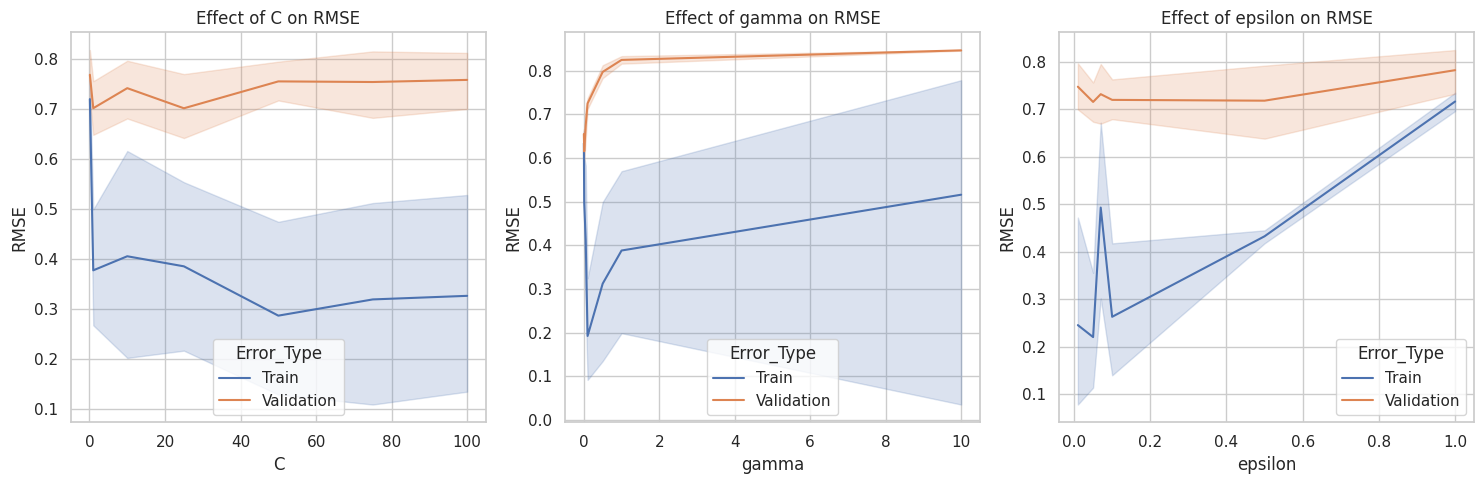

In [ ]:
# 绘制超参数搜索结果图，多幅图，每幅图展示一个超参数对模型性能的影响
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=model_metrics, x='C', y='RMSE', hue='Error_Type')
plt.title('Effect of C on RMSE')
plt.xlabel('C')
plt.ylabel('RMSE')
plt.subplot(1, 3, 2)
sns.lineplot(data=model_metrics, x='gamma', y='RMSE', hue='Error_Type')
plt.title('Effect of gamma on RMSE')
plt.xlabel('gamma')
plt.ylabel('RMSE')
plt.subplot(1, 3, 3)
sns.lineplot(data=model_metrics, x='epsilon', y='RMSE', hue='Error_Type')
plt.title('Effect of epsilon on RMSE')
plt.xlabel('epsilon')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

### Test

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  10.3s
Model training completed!
[Train Error] Evaluating DFT SVR on train set:


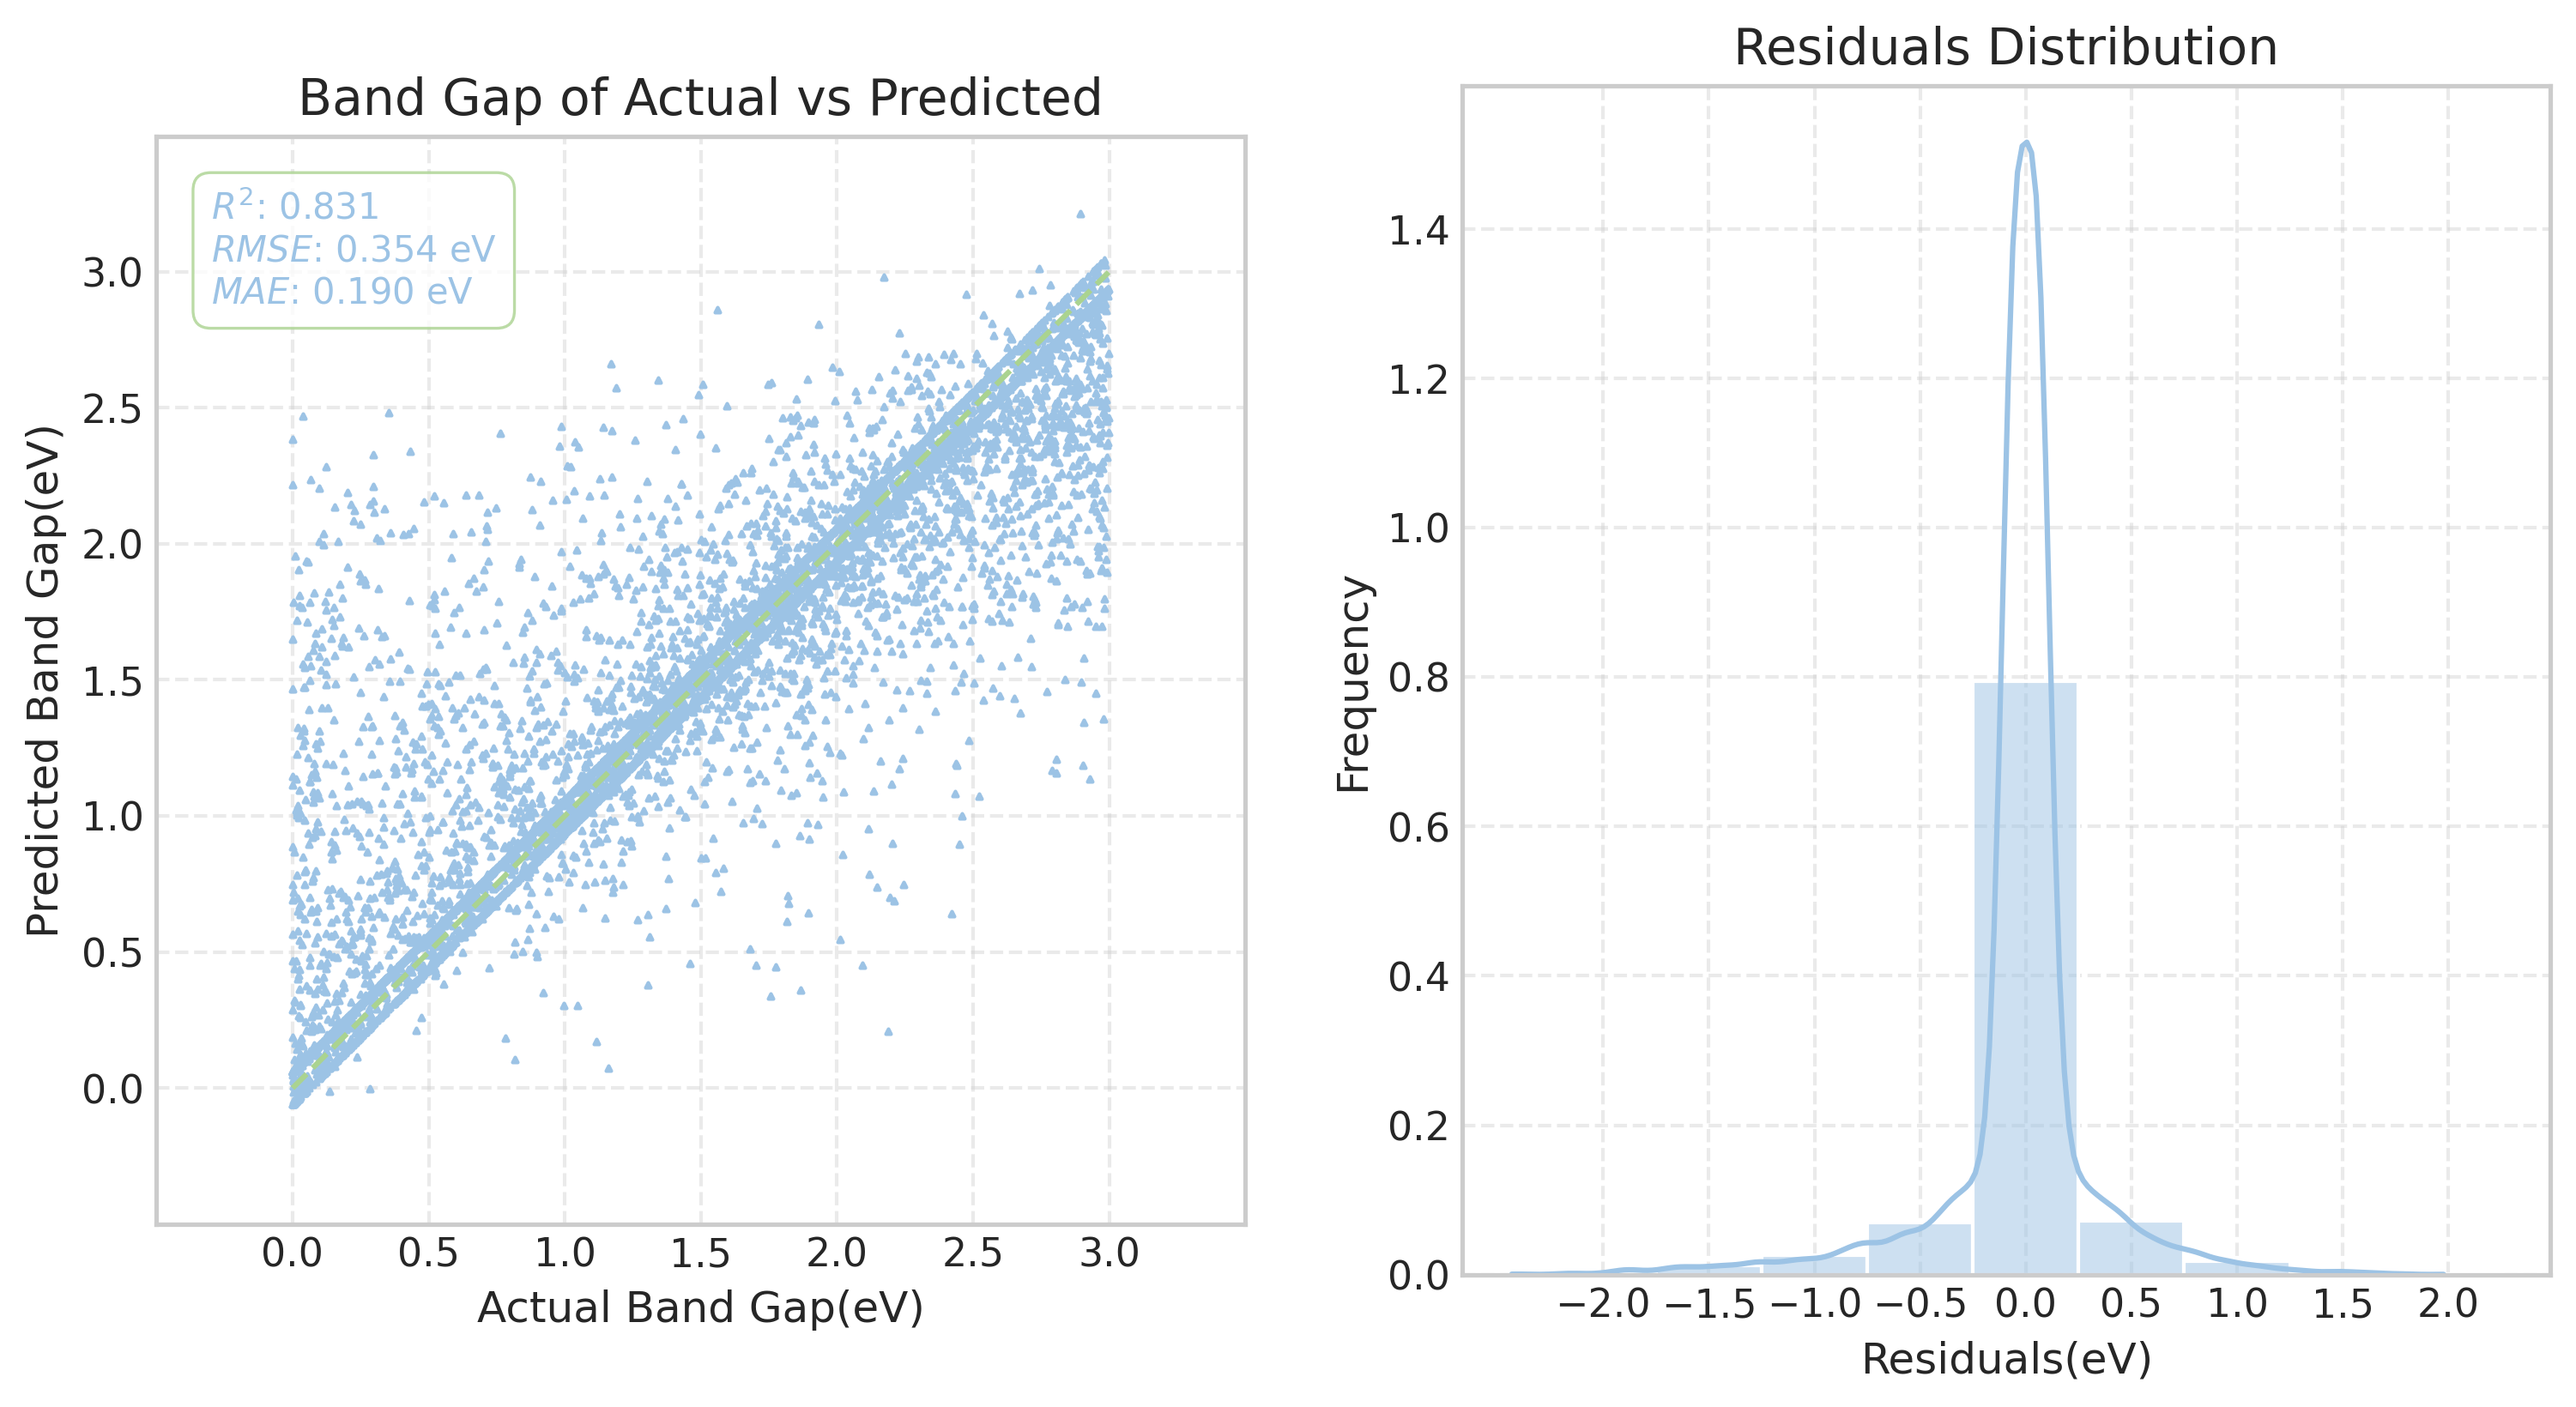


Model Evaluation Results:
Test set size: 8268
Test set: R²: 0.8310 RMSE: 0.3541 MAE: 0.1903 MAPE: 1152.7624%
[Test Error] Evaluating DFT SVR on test set:


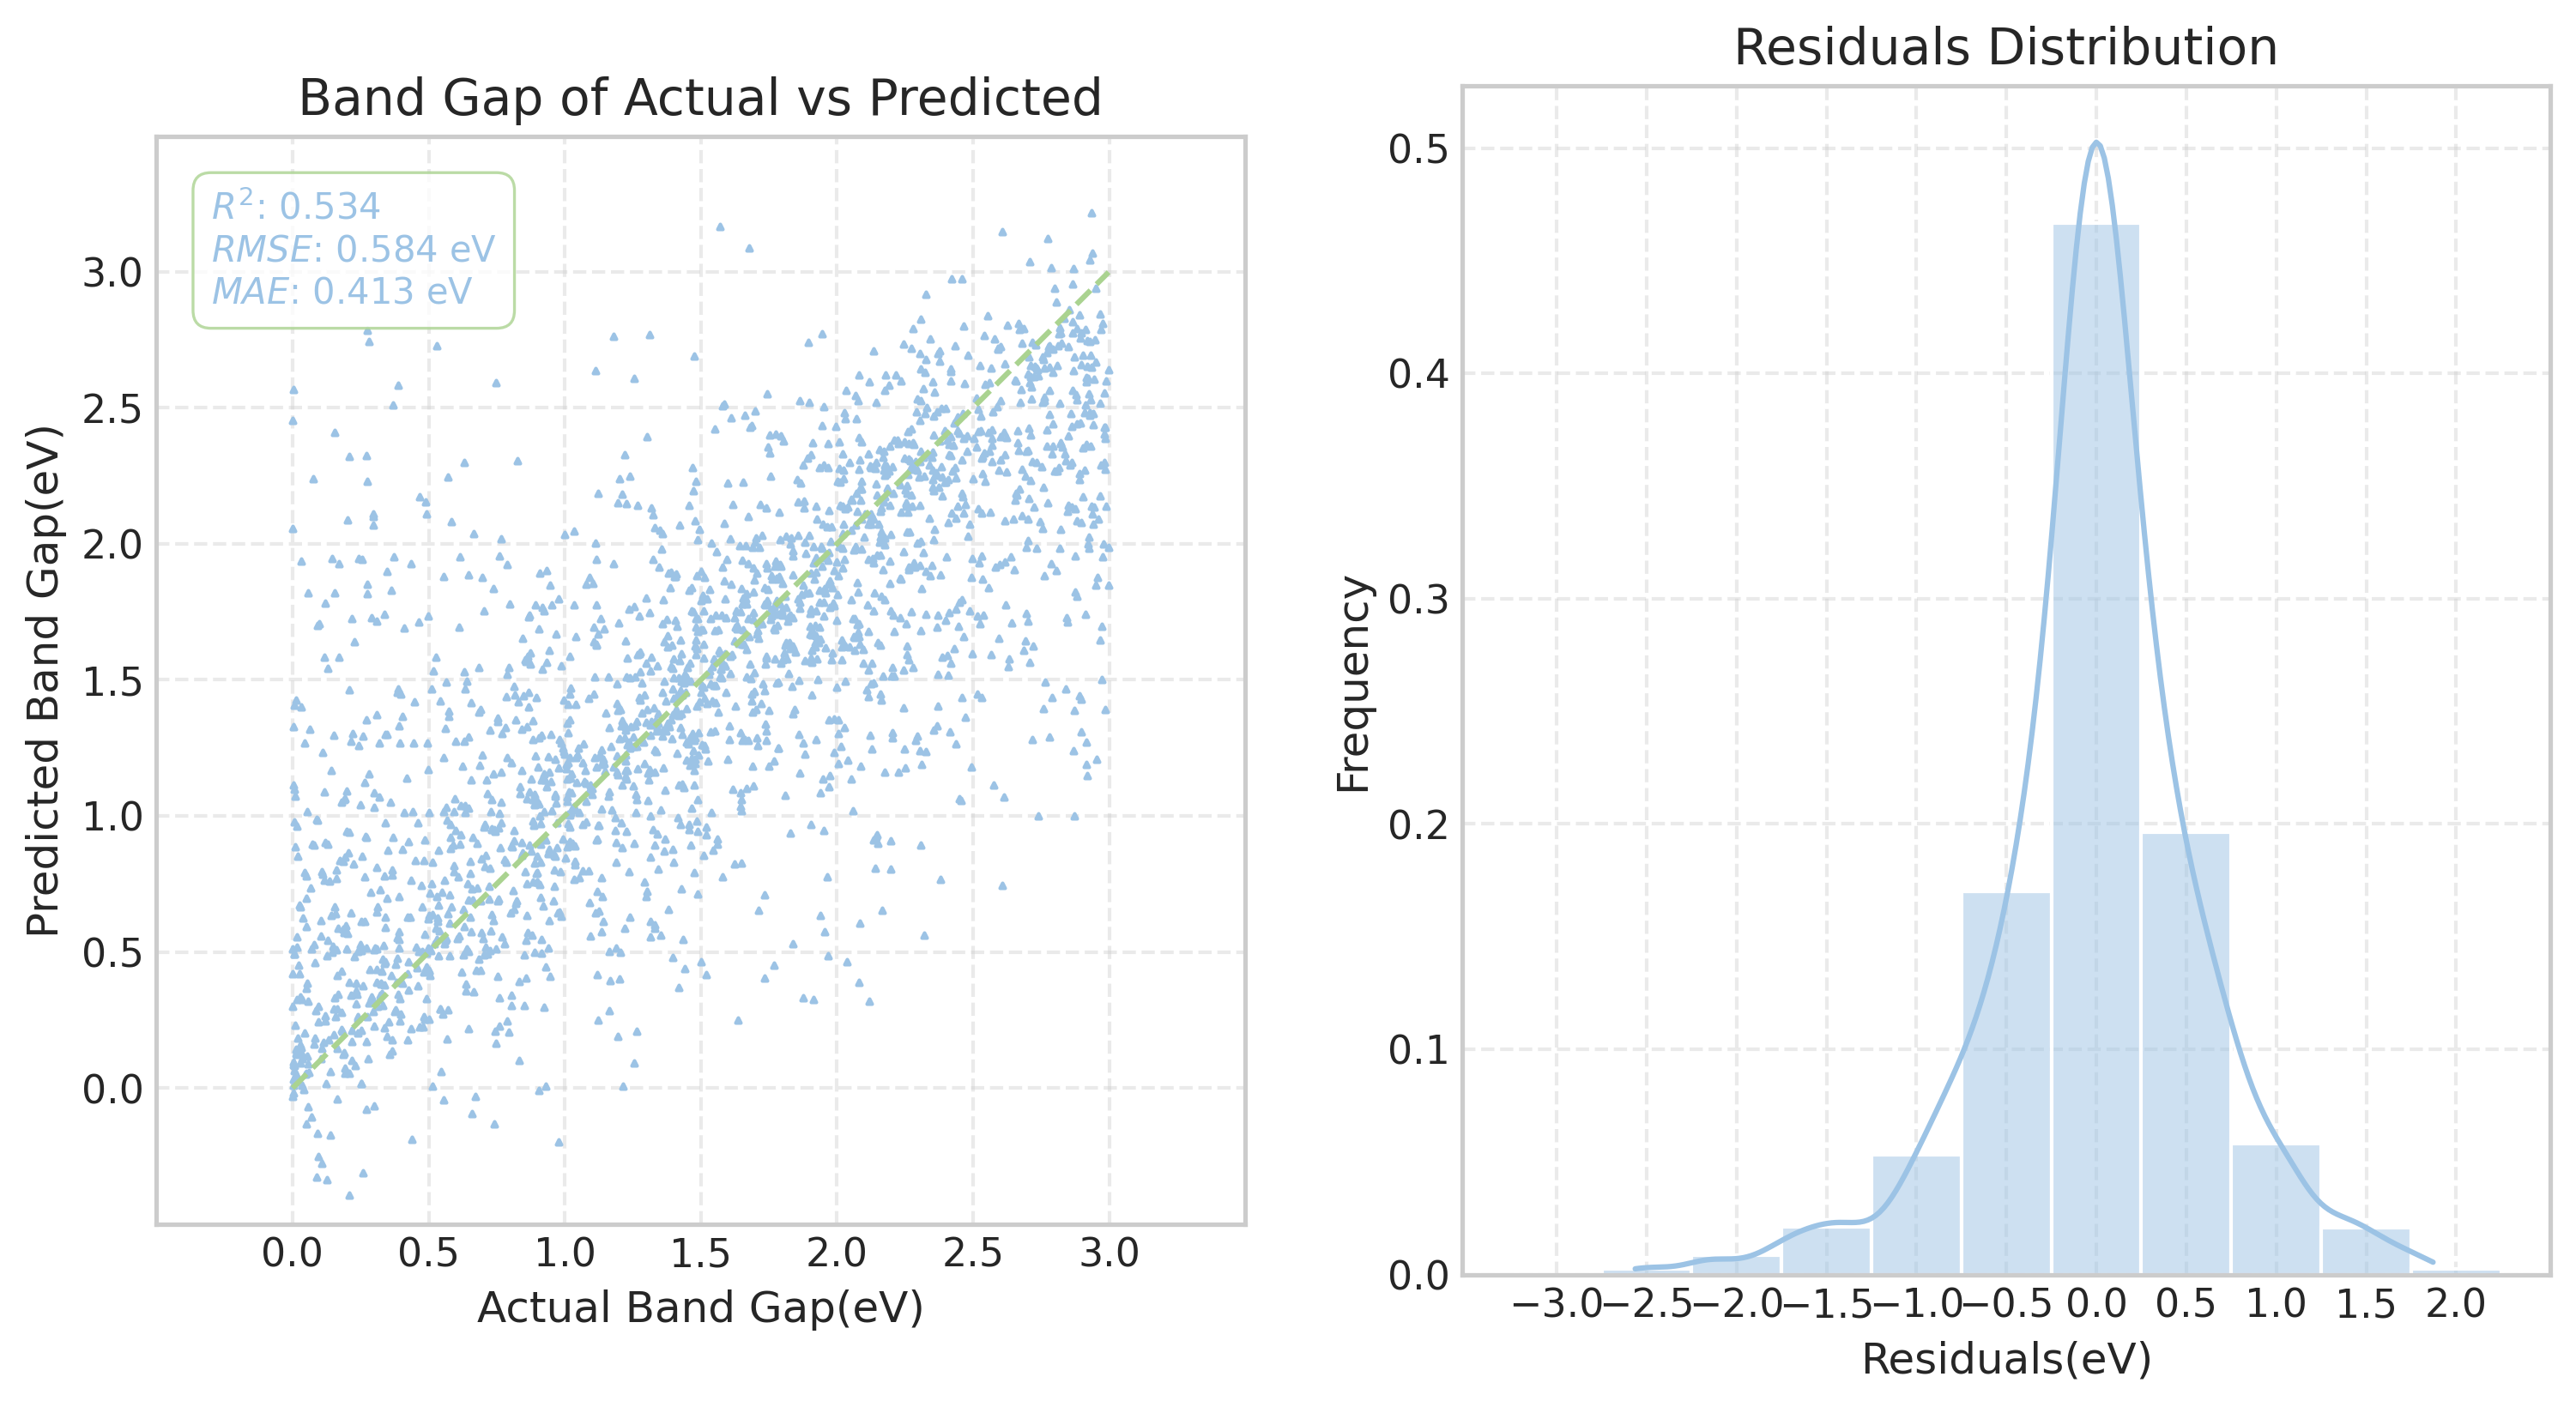


Model Evaluation Results:
Test set size: 2074
Test set: R²: 0.5336 RMSE: 0.5841 MAE: 0.4130 MAPE: 1053.8467%


In [ ]:
best_svr = SVR(kernel='rbf', C=best_val_params['C'], epsilon=best_val_params['epsilon'], gamma=best_val_params['gamma'])
model = SingleModel(model=best_svr)
model.train(dft_all_train_X, dft_all_train_y)
# evaluate on the dft train set
print(f"[Train Error] Evaluating DFT {MODEL_NAME} on train set:")
    
train_metrics = model.evaluate(dft_all_train_X, dft_all_train_y, fig_show=True)
# evaluate on the dft test set
print(f"[Test Error] Evaluating DFT {MODEL_NAME} on test set:")
test_metrics = model.evaluate(dft_test_X, dft_test_y, fig_show=True)